In [1]:
from common import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import logging, time
from sklearn.model_selection import train_test_split
import data_flow
import train
import gc

# Prepare data

In [2]:
fnames = glob('../data/corpus/**.txt')

In [134]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [143]:
docs = []
ids = []
for fn in tqdm_notebook(fnames[:]):
    with open(fn, 'rb') as f:
        ixs = [int(_ix) for _ix in f.read().split()]
    if len(ixs) == 0:
        print(fn)
        continue
    doc_vec = word_embeddings[ixs].mean(axis=0)
    docs.append(doc_vec)
    ids.append(basename(fn).split('.')[0])

../data/corpus/5984b653b6b11311aa638537.txt
../data/corpus/5984b69db6b1131591638547.txt
../data/corpus/5984b6fdb6b1131ae26384f4.txt
../data/corpus/5984b667b6b11313926384f7.txt
../data/corpus/5984b690b6b113159263850f.txt
../data/corpus/5984b65db6b1131294638541.txt
../data/corpus/5984b6bab6b11317b963851c.txt
../data/corpus/5984b592b6b113049f638531.txt
../data/corpus/5984b6bab6b11317a16384fd.txt
../data/corpus/5984b6a3b6b11316a563850e.txt
../data/corpus/5984b589b6b11304986384fd.txt
../data/corpus/5984b6c1b6b11317b0638527.txt
../data/corpus/5984b6bbb6b11317a163852f.txt
../data/corpus/5984b6bbb6b11317a1638546.txt
../data/corpus/5984b58fb6b1130489638517.txt
../data/corpus/5984b68fb6b11315926384f3.txt
../data/corpus/5984b68fb6b1131592638508.txt
../data/corpus/5984b58fb6b11304a963852e.txt
../data/corpus/5984b6bbb6b11317a1638536.txt
../data/corpus/5984b6a4b6b113169a638532.txt
../data/corpus/5984b6bab6b11317a163850f.txt
../data/corpus/5984b6c2b6b11317b8638545.txt
../data/corpus/5984b6c1b6b11317b

In [146]:
np.save('../data/avged_docs.npy', docs)
np.save('../data/avged_ids.npy', ids)

# Load data

In [2]:
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [3]:
_docs = np.load('../data/avged_docs.npy')
ids = np.load('../data/avged_ids.npy')
docs = pd.DataFrame(_docs, index=ids)
docs.sort_index(inplace=True)

# try unsupervised

In [4]:
val_vecs = []
for _id in tqdm_notebook(gold.keys()):
    ix = np.where(ids == _id)[0][0]
    val_vecs.append(_docs[ix])

In [5]:
sim_mat = cosine_similarity(val_vecs, _docs)

In [6]:
best = {}
for i, vec in enumerate(tqdm_notebook(sim_mat)):
    val_name = gold.keys()[i]
    train_ixs = vec.argsort()[-200:][::-1]
    top_train = [ids[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 184/184 [00:00<00:00, 36785.13it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.273007
acc20     0.355435
acc200    0.535145
dtype: float64


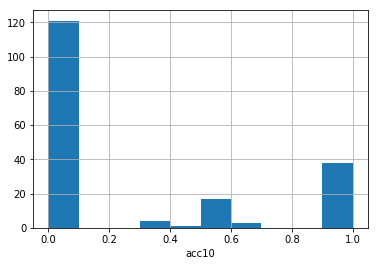

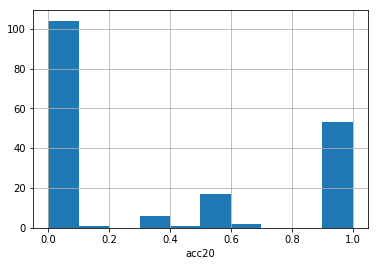

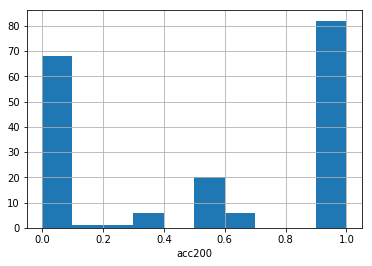

In [7]:
result = evaluate(best, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [9]:
for i, (k, v) in enumerate(gold.items()):
    if len(set(v).intersection(best[k])) == 0:
        print(i, k)

(0, u'59a7bc6c782b1b893a56a8a9')
(3, u'59a7bc6c782b1b893a56a89f')
(10, u'59a7bc66782b1b893a56a844')
(14, u'59a7bc6a782b1b893a56a87c')
(15, u'59a7bc6a782b1b893a56a87a')
(16, u'59a7bc6a782b1b893a56a87e')
(21, u'59a7bc59782b1b893a56a753')
(25, u'59a7bc59782b1b893a56a751')
(27, u'59a7bc59782b1b893a56a759')
(28, u'59a7bc65782b1b893a56a831')
(29, u'59a7bc62782b1b893a56a812')
(31, u'59a7bc5d782b1b893a56a7a7')
(35, u'59a7bc6d782b1b893a56a8b3')
(36, u'59a7bc67782b1b893a56a856')
(40, u'59a7bc6b782b1b893a56a897')
(41, u'59a7bc6d782b1b893a56a8b9')
(42, u'59a7bc67782b1b893a56a858')
(48, u'59a7bc5d782b1b893a56a7a9')
(50, u'59a7bc60782b1b893a56a7e7')
(53, u'59a7bc69782b1b893a56a875')
(55, u'59a7bc5b782b1b893a56a78b')
(56, u'59a7bc6f782b1b893a56a8e6')
(57, u'59a7bc6f782b1b893a56a8e4')
(59, u'59a7bc6f782b1b893a56a8e0')
(67, u'59a7bc6a782b1b893a56a882')
(71, u'59a7bc5f782b1b893a56a7cf')
(72, u'59a7bc6d782b1b893a56a8bf')
(73, u'59a7bc5f782b1b893a56a7cd')
(78, u'59a7bc65782b1b893a56a82f')
(80, u'59a7bc5b7

In [15]:
gold['59a7bc6e782b1b893a56a8c9']

[u'5984b952b6b1133dab63852f']

In [21]:
best['59a7bc6e782b1b893a56a8c9'][2]

'5984dd43b6b11333b56384fc'

# try supervised

In [4]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, with_path=False, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)
gc.collect()

100%|██████████| 368458/368458 [00:03<00:00, 97042.10it/s] 


0

In [5]:
embedding_size = 300
batch_size = 64
learning_rate = 0.001
sizes=[300, 200]

In [8]:
reload(train)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')

        model = train.FCNN(batch_size=batch_size, sizes=sizes, 
                        learning_rate=learning_rate,
                        batch_norm=True)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary('train')
#         model.init_summary('val')

        tr_batch = data_flow.gen_batches(docs, triples_train[:batch_size*500], batch_size)
#         val_batch = data_flow.gen_batches(docs, triples_val, 64)

        for step, X_train in enumerate(tr_batch):
            assert not X_train.isnull().values.any()
            _, loss, summary, _embeds = sess.run([
                train_op, model.loss_op,
                model.merged_summary_op, model.negative
            ], feed_dict = {model.phase: 1, 'X:0': X_train})
            model.add_summary(summary, step)
            logging.info('step %s, loss %s' % (step, loss))
            
#             if (step + 1) %  50 == 0:
#                 X_val = next(val_batch)
#                 [val_loss] = sess.run([loss], 
#                               feed_dict={'X:0': X_val,
#                                          'phase:0': 0})
#             if (step + 1) %  50 == 0:
#                 [test_loss, t20, t200] = sess.run([loss, top20, top200], 
#                              feed_dict={'X:0': X_test,
#                                         'phase:0': 0})
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
#     send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-09-27 09:16:00,501 [MainThread  ] [INFO ]  start training ...
2017-09-27 09:16:02,516 [MainThread  ] [INFO ]  step 0, loss 0.025131
2017-09-27 09:16:02,535 [MainThread  ] [INFO ]  step 1, loss 0.0160408
2017-09-27 09:16:02,557 [MainThread  ] [INFO ]  step 2, loss 0.00514053
2017-09-27 09:16:02,577 [MainThread  ] [INFO ]  step 3, loss 0.00400701
2017-09-27 09:16:02,602 [MainThread  ] [INFO ]  step 4, loss 0.00377259
2017-09-27 09:16:02,623 [MainThread  ] [INFO ]  step 5, loss 0.0104991
2017-09-27 09:16:02,644 [MainThread  ] [INFO ]  step 6, loss 0.0
2017-09-27 09:16:02,661 [MainThread  ] [INFO ]  step 7, loss 0.0379961
2017-09-27 09:16:02,683 [MainThread  ] [INFO ]  step 8, loss 0.00611348
2017-09-27 09:16:02,703 [MainThread  ] [INFO ]  step 9, loss 0.0147015
2017-09-27 09:16:02,723 [MainThread  ] [INFO ]  step 10, loss 0.00353007
2017-09-27 09:16:02,840 [MainThread  ] [INFO ]  step 11, loss 0.0114312
2017-09-27 09:16:02,861 [MainThread  ] [INFO ]  step 12, loss 0.0388783
2017-09-2

2017-09-27 09:16:05,968 [MainThread  ] [INFO ]  step 114, loss 0.0171225
2017-09-27 09:16:05,983 [MainThread  ] [INFO ]  step 115, loss 0.0043322
2017-09-27 09:16:06,002 [MainThread  ] [INFO ]  step 116, loss 0.00196466
2017-09-27 09:16:06,019 [MainThread  ] [INFO ]  step 117, loss 0.0126337
2017-09-27 09:16:06,036 [MainThread  ] [INFO ]  step 118, loss 0.00412537
2017-09-27 09:16:06,052 [MainThread  ] [INFO ]  step 119, loss 0.0
2017-09-27 09:16:06,069 [MainThread  ] [INFO ]  step 120, loss 0.0146328
2017-09-27 09:16:06,088 [MainThread  ] [INFO ]  step 121, loss 0.00216128
2017-09-27 09:16:06,107 [MainThread  ] [INFO ]  step 122, loss 0.0
2017-09-27 09:16:06,124 [MainThread  ] [INFO ]  step 123, loss 0.00464432
2017-09-27 09:16:06,142 [MainThread  ] [INFO ]  step 124, loss 0.0170355
2017-09-27 09:16:06,158 [MainThread  ] [INFO ]  step 125, loss 0.00507082
2017-09-27 09:16:06,174 [MainThread  ] [INFO ]  step 126, loss 0.00017658
2017-09-27 09:16:06,289 [MainThread  ] [INFO ]  step 127,

2017-09-27 09:16:08,993 [MainThread  ] [INFO ]  step 227, loss 0.00568847
2017-09-27 09:16:09,010 [MainThread  ] [INFO ]  step 228, loss 0.0
2017-09-27 09:16:09,027 [MainThread  ] [INFO ]  step 229, loss 0.00666664
2017-09-27 09:16:09,043 [MainThread  ] [INFO ]  step 230, loss 0.00649712
2017-09-27 09:16:09,058 [MainThread  ] [INFO ]  step 231, loss 0.00716792
2017-09-27 09:16:09,074 [MainThread  ] [INFO ]  step 232, loss 0.000280691
2017-09-27 09:16:09,088 [MainThread  ] [INFO ]  step 233, loss 0.000118678
2017-09-27 09:16:09,104 [MainThread  ] [INFO ]  step 234, loss 0.0
2017-09-27 09:16:09,121 [MainThread  ] [INFO ]  step 235, loss 0.000407699
2017-09-27 09:16:09,137 [MainThread  ] [INFO ]  step 236, loss 0.000719817
2017-09-27 09:16:09,157 [MainThread  ] [INFO ]  step 237, loss 0.00029349
2017-09-27 09:16:09,175 [MainThread  ] [INFO ]  step 238, loss 0.00332234
2017-09-27 09:16:09,297 [MainThread  ] [INFO ]  step 239, loss 0.0118575
2017-09-27 09:16:09,415 [MainThread  ] [INFO ]  s

2017-09-27 09:16:12,050 [MainThread  ] [INFO ]  step 340, loss 0.000655139
2017-09-27 09:16:12,068 [MainThread  ] [INFO ]  step 341, loss 0.0
2017-09-27 09:16:12,088 [MainThread  ] [INFO ]  step 342, loss 0.0113413
2017-09-27 09:16:12,104 [MainThread  ] [INFO ]  step 343, loss 0.00971594
2017-09-27 09:16:12,119 [MainThread  ] [INFO ]  step 344, loss 1.86637e-05
2017-09-27 09:16:12,135 [MainThread  ] [INFO ]  step 345, loss 0.0219246
2017-09-27 09:16:12,150 [MainThread  ] [INFO ]  step 346, loss 0.0124416
2017-09-27 09:16:12,269 [MainThread  ] [INFO ]  step 347, loss 0.00308442
2017-09-27 09:16:12,287 [MainThread  ] [INFO ]  step 348, loss 0.0134331
2017-09-27 09:16:12,404 [MainThread  ] [INFO ]  step 349, loss 0.00380235
2017-09-27 09:16:12,421 [MainThread  ] [INFO ]  step 350, loss 0.0159787
2017-09-27 09:16:12,438 [MainThread  ] [INFO ]  step 351, loss 0.00124174
2017-09-27 09:16:12,454 [MainThread  ] [INFO ]  step 352, loss 0.00315557
2017-09-27 09:16:12,470 [MainThread  ] [INFO ]  

2017-09-27 09:16:15,749 [MainThread  ] [INFO ]  step 453, loss 0.00876
2017-09-27 09:16:15,767 [MainThread  ] [INFO ]  step 454, loss 0.0036259
2017-09-27 09:16:15,782 [MainThread  ] [INFO ]  step 455, loss 0.0
2017-09-27 09:16:15,799 [MainThread  ] [INFO ]  step 456, loss 0.0
2017-09-27 09:16:15,817 [MainThread  ] [INFO ]  step 457, loss 0.0145025
2017-09-27 09:16:15,832 [MainThread  ] [INFO ]  step 458, loss 0.0025853
2017-09-27 09:16:15,850 [MainThread  ] [INFO ]  step 459, loss 0.0
2017-09-27 09:16:15,866 [MainThread  ] [INFO ]  step 460, loss 0.0279768
2017-09-27 09:16:15,880 [MainThread  ] [INFO ]  step 461, loss 0.00180355
2017-09-27 09:16:15,898 [MainThread  ] [INFO ]  step 462, loss 0.0112772
2017-09-27 09:16:16,013 [MainThread  ] [INFO ]  step 463, loss 0.0039368
2017-09-27 09:16:16,129 [MainThread  ] [INFO ]  step 464, loss 0.0
2017-09-27 09:16:16,146 [MainThread  ] [INFO ]  step 465, loss 0.0
2017-09-27 09:16:16,165 [MainThread  ] [INFO ]  step 466, loss 0.0107325
2017-09-2

# Test

In [152]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-26 11:15:09.052459-59.meta
../data/models/2017-09-26 11:15:29.820761-99.meta
../data/models/2017-09-26 11:15:56.925237-119.meta
../data/models/2017-09-26 11:16:17.511134-129.meta
../data/models/2017-09-26 11:16:31.954300-139.meta
../data/models/2017-09-26 11:16:46.771881-149.meta
../data/models/2017-09-26 11:16:59.498404-159.meta
../data/models/2017-09-26 11:17:36.095400-160.meta
../data/models/2017-09-26 11:17:56.311153-161.meta
../data/models/2017-09-26 11:18:11.756090-162.meta
../data/models/2017-09-26 11:21:17.669527-162.meta
../data/models/2017-09-26 11:22:00.079404-199.meta
../data/models/2017-09-26 11:22:14.470317-199.meta
../data/models/2017-09-26 11:22:44.619330-160.meta
../data/models/2017-09-26 11:23:07.798019-160.meta
../data/models/2017-09-26 11:23:21.365907-161.meta
../data/models/2017-09-26 12:09:13.085158-161.meta
../data/models/2017-09-26 12:30:52.304624-999.meta
../data/models/2017-09-26 12:46:51.576442-999.meta
../data/models/2017-09-26 12:51:1

In [153]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [154]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunked = list(chunks(ids, 3))
print(chunked.pop())
logging.info('len(chunked) = %s' % len(chunked))

2017-09-26 14:33:08,998 [MainThread  ] [INFO ]  len(chunked) = 422379


['5984be6db6b1137db5638517' '5984b84fb6b1132eeb638535']


In [155]:
doc_embeds, fnames, losses = [], [], []

In [156]:
finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')
        
        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, sizes[-1]]),
            3, 1)
        _loss = train.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        test_batch = data_flow.gen_batches(docs, chunked[:], batch_size)

        step = 0
        for step, X_test in enumerate(test_batch):
            [batch_embeds, loss] = sess.run([doc_embed_normalized, _loss],
                                           feed_dict = {'init_model/phase:0': 0, 'X:0': X_test})
            doc_embeds.append(batch_embeds)
            logging.info('step %s, loss %s' % (step, loss))
            step+=1
            losses.append(loss)
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

INFO:tensorflow:Restoring parameters from ../data/models/2017-09-26 14:33:07.082921-9681


2017-09-26 14:33:10,084 [MainThread  ] [INFO ]  Restoring parameters from ../data/models/2017-09-26 14:33:07.082921-9681
2017-09-26 14:33:10,557 [MainThread  ] [INFO ]  step 0, loss 0.802209
2017-09-26 14:33:10,565 [MainThread  ] [INFO ]  step 1, loss 0.749191
2017-09-26 14:33:10,574 [MainThread  ] [INFO ]  step 2, loss 0.850092
2017-09-26 14:33:10,582 [MainThread  ] [INFO ]  step 3, loss 0.784718
2017-09-26 14:33:10,595 [MainThread  ] [INFO ]  step 4, loss 0.822686
2017-09-26 14:33:10,603 [MainThread  ] [INFO ]  step 5, loss 0.767308
2017-09-26 14:33:10,616 [MainThread  ] [INFO ]  step 6, loss 0.764526
2017-09-26 14:33:10,627 [MainThread  ] [INFO ]  step 7, loss 0.744123
2017-09-26 14:33:10,635 [MainThread  ] [INFO ]  step 8, loss 0.881124
2017-09-26 14:33:10,646 [MainThread  ] [INFO ]  step 9, loss 0.83031
2017-09-26 14:33:10,658 [MainThread  ] [INFO ]  step 10, loss 0.83362
2017-09-26 14:33:10,666 [MainThread  ] [INFO ]  step 11, loss 0.765588
2017-09-26 14:33:10,676 [MainThread  ] 

2017-09-26 14:33:11,524 [MainThread  ] [INFO ]  step 114, loss 0.824839
2017-09-26 14:33:11,530 [MainThread  ] [INFO ]  step 115, loss 0.857049
2017-09-26 14:33:11,538 [MainThread  ] [INFO ]  step 116, loss 0.797897
2017-09-26 14:33:11,545 [MainThread  ] [INFO ]  step 117, loss 0.803211
2017-09-26 14:33:11,552 [MainThread  ] [INFO ]  step 118, loss 0.908572
2017-09-26 14:33:11,559 [MainThread  ] [INFO ]  step 119, loss 0.782706
2017-09-26 14:33:11,566 [MainThread  ] [INFO ]  step 120, loss 0.762471
2017-09-26 14:33:11,574 [MainThread  ] [INFO ]  step 121, loss 0.723831
2017-09-26 14:33:11,581 [MainThread  ] [INFO ]  step 122, loss 0.895482
2017-09-26 14:33:11,588 [MainThread  ] [INFO ]  step 123, loss 0.841692
2017-09-26 14:33:11,595 [MainThread  ] [INFO ]  step 124, loss 0.79958
2017-09-26 14:33:11,602 [MainThread  ] [INFO ]  step 125, loss 0.687663
2017-09-26 14:33:11,610 [MainThread  ] [INFO ]  step 126, loss 0.829806
2017-09-26 14:33:11,616 [MainThread  ] [INFO ]  step 127, loss 0.

2017-09-26 14:33:12,423 [MainThread  ] [INFO ]  step 228, loss 0.923088
2017-09-26 14:33:12,433 [MainThread  ] [INFO ]  step 229, loss 0.806932
2017-09-26 14:33:12,444 [MainThread  ] [INFO ]  step 230, loss 0.776965
2017-09-26 14:33:12,453 [MainThread  ] [INFO ]  step 231, loss 0.892499
2017-09-26 14:33:12,466 [MainThread  ] [INFO ]  step 232, loss 0.867105
2017-09-26 14:33:12,475 [MainThread  ] [INFO ]  step 233, loss 0.769051
2017-09-26 14:33:12,484 [MainThread  ] [INFO ]  step 234, loss 0.851234
2017-09-26 14:33:12,492 [MainThread  ] [INFO ]  step 235, loss 0.794787
2017-09-26 14:33:12,500 [MainThread  ] [INFO ]  step 236, loss 0.824226
2017-09-26 14:33:12,506 [MainThread  ] [INFO ]  step 237, loss 0.782997
2017-09-26 14:33:12,518 [MainThread  ] [INFO ]  step 238, loss 0.87826
2017-09-26 14:33:12,528 [MainThread  ] [INFO ]  step 239, loss 0.835453
2017-09-26 14:33:12,535 [MainThread  ] [INFO ]  step 240, loss 0.860233
2017-09-26 14:33:12,542 [MainThread  ] [INFO ]  step 241, loss 0.

2017-09-26 14:33:13,348 [MainThread  ] [INFO ]  step 342, loss 0.780036
2017-09-26 14:33:13,354 [MainThread  ] [INFO ]  step 343, loss 0.825004
2017-09-26 14:33:13,361 [MainThread  ] [INFO ]  step 344, loss 0.800465
2017-09-26 14:33:13,369 [MainThread  ] [INFO ]  step 345, loss 0.84455
2017-09-26 14:33:13,378 [MainThread  ] [INFO ]  step 346, loss 0.839635
2017-09-26 14:33:13,385 [MainThread  ] [INFO ]  step 347, loss 0.776925
2017-09-26 14:33:13,392 [MainThread  ] [INFO ]  step 348, loss 0.815189
2017-09-26 14:33:13,401 [MainThread  ] [INFO ]  step 349, loss 0.825888
2017-09-26 14:33:13,411 [MainThread  ] [INFO ]  step 350, loss 0.803105
2017-09-26 14:33:13,420 [MainThread  ] [INFO ]  step 351, loss 0.874306
2017-09-26 14:33:13,429 [MainThread  ] [INFO ]  step 352, loss 0.723211
2017-09-26 14:33:13,437 [MainThread  ] [INFO ]  step 353, loss 0.811648
2017-09-26 14:33:13,446 [MainThread  ] [INFO ]  step 354, loss 0.712472
2017-09-26 14:33:13,453 [MainThread  ] [INFO ]  step 355, loss 0.

2017-09-26 14:33:14,258 [MainThread  ] [INFO ]  step 456, loss 0.794331
2017-09-26 14:33:14,268 [MainThread  ] [INFO ]  step 457, loss 0.740257
2017-09-26 14:33:14,278 [MainThread  ] [INFO ]  step 458, loss 0.757548
2017-09-26 14:33:14,286 [MainThread  ] [INFO ]  step 459, loss 0.781002
2017-09-26 14:33:14,293 [MainThread  ] [INFO ]  step 460, loss 0.828227
2017-09-26 14:33:14,304 [MainThread  ] [INFO ]  step 461, loss 0.835574
2017-09-26 14:33:14,310 [MainThread  ] [INFO ]  step 462, loss 0.819052
2017-09-26 14:33:14,320 [MainThread  ] [INFO ]  step 463, loss 0.813136
2017-09-26 14:33:14,326 [MainThread  ] [INFO ]  step 464, loss 0.76157
2017-09-26 14:33:14,334 [MainThread  ] [INFO ]  step 465, loss 0.85083
2017-09-26 14:33:14,340 [MainThread  ] [INFO ]  step 466, loss 0.739573
2017-09-26 14:33:14,348 [MainThread  ] [INFO ]  step 467, loss 0.807184
2017-09-26 14:33:14,356 [MainThread  ] [INFO ]  step 468, loss 0.847294
2017-09-26 14:33:14,362 [MainThread  ] [INFO ]  step 469, loss 0.7

2017-09-26 14:33:15,242 [MainThread  ] [INFO ]  step 570, loss 0.783468
2017-09-26 14:33:15,250 [MainThread  ] [INFO ]  step 571, loss 0.802323
2017-09-26 14:33:15,258 [MainThread  ] [INFO ]  step 572, loss 0.84663
2017-09-26 14:33:15,266 [MainThread  ] [INFO ]  step 573, loss 0.780935
2017-09-26 14:33:15,274 [MainThread  ] [INFO ]  step 574, loss 0.775636
2017-09-26 14:33:15,283 [MainThread  ] [INFO ]  step 575, loss 0.786842
2017-09-26 14:33:15,292 [MainThread  ] [INFO ]  step 576, loss 0.741597
2017-09-26 14:33:15,301 [MainThread  ] [INFO ]  step 577, loss 0.82315
2017-09-26 14:33:15,312 [MainThread  ] [INFO ]  step 578, loss 0.796282
2017-09-26 14:33:15,320 [MainThread  ] [INFO ]  step 579, loss 0.853586
2017-09-26 14:33:15,332 [MainThread  ] [INFO ]  step 580, loss 0.862008
2017-09-26 14:33:15,340 [MainThread  ] [INFO ]  step 581, loss 0.834105
2017-09-26 14:33:15,350 [MainThread  ] [INFO ]  step 582, loss 0.800447
2017-09-26 14:33:15,357 [MainThread  ] [INFO ]  step 583, loss 0.7

2017-09-26 14:33:16,238 [MainThread  ] [INFO ]  step 684, loss 0.74332
2017-09-26 14:33:16,245 [MainThread  ] [INFO ]  step 685, loss 0.765935
2017-09-26 14:33:16,254 [MainThread  ] [INFO ]  step 686, loss 0.899158
2017-09-26 14:33:16,264 [MainThread  ] [INFO ]  step 687, loss 0.910522
2017-09-26 14:33:16,272 [MainThread  ] [INFO ]  step 688, loss 0.840971
2017-09-26 14:33:16,281 [MainThread  ] [INFO ]  step 689, loss 0.741687
2017-09-26 14:33:16,291 [MainThread  ] [INFO ]  step 690, loss 0.772132
2017-09-26 14:33:16,300 [MainThread  ] [INFO ]  step 691, loss 0.818631
2017-09-26 14:33:16,307 [MainThread  ] [INFO ]  step 692, loss 0.869868
2017-09-26 14:33:16,316 [MainThread  ] [INFO ]  step 693, loss 0.88571
2017-09-26 14:33:16,323 [MainThread  ] [INFO ]  step 694, loss 0.770012
2017-09-26 14:33:16,339 [MainThread  ] [INFO ]  step 695, loss 0.795802
2017-09-26 14:33:16,346 [MainThread  ] [INFO ]  step 696, loss 0.844028
2017-09-26 14:33:16,355 [MainThread  ] [INFO ]  step 697, loss 0.8

2017-09-26 14:33:17,205 [MainThread  ] [INFO ]  step 798, loss 0.89567
2017-09-26 14:33:17,212 [MainThread  ] [INFO ]  step 799, loss 0.800864
2017-09-26 14:33:17,220 [MainThread  ] [INFO ]  step 800, loss 0.754736
2017-09-26 14:33:17,227 [MainThread  ] [INFO ]  step 801, loss 0.792473
2017-09-26 14:33:17,235 [MainThread  ] [INFO ]  step 802, loss 0.825189
2017-09-26 14:33:17,242 [MainThread  ] [INFO ]  step 803, loss 0.784895
2017-09-26 14:33:17,252 [MainThread  ] [INFO ]  step 804, loss 0.792173
2017-09-26 14:33:17,260 [MainThread  ] [INFO ]  step 805, loss 0.743263
2017-09-26 14:33:17,269 [MainThread  ] [INFO ]  step 806, loss 0.819481
2017-09-26 14:33:17,277 [MainThread  ] [INFO ]  step 807, loss 0.745553
2017-09-26 14:33:17,288 [MainThread  ] [INFO ]  step 808, loss 0.755291
2017-09-26 14:33:17,295 [MainThread  ] [INFO ]  step 809, loss 0.791601
2017-09-26 14:33:17,305 [MainThread  ] [INFO ]  step 810, loss 0.81581
2017-09-26 14:33:17,312 [MainThread  ] [INFO ]  step 811, loss 0.8

2017-09-26 14:33:18,099 [MainThread  ] [INFO ]  step 912, loss 0.858327
2017-09-26 14:33:18,106 [MainThread  ] [INFO ]  step 913, loss 0.762679
2017-09-26 14:33:18,113 [MainThread  ] [INFO ]  step 914, loss 0.868282
2017-09-26 14:33:18,120 [MainThread  ] [INFO ]  step 915, loss 0.827741
2017-09-26 14:33:18,126 [MainThread  ] [INFO ]  step 916, loss 0.844871
2017-09-26 14:33:18,133 [MainThread  ] [INFO ]  step 917, loss 0.772435
2017-09-26 14:33:18,139 [MainThread  ] [INFO ]  step 918, loss 0.772823
2017-09-26 14:33:18,148 [MainThread  ] [INFO ]  step 919, loss 0.797196
2017-09-26 14:33:18,155 [MainThread  ] [INFO ]  step 920, loss 0.838304
2017-09-26 14:33:18,164 [MainThread  ] [INFO ]  step 921, loss 0.74774
2017-09-26 14:33:18,170 [MainThread  ] [INFO ]  step 922, loss 0.880137
2017-09-26 14:33:18,176 [MainThread  ] [INFO ]  step 923, loss 0.820731
2017-09-26 14:33:18,184 [MainThread  ] [INFO ]  step 924, loss 0.80976
2017-09-26 14:33:18,192 [MainThread  ] [INFO ]  step 925, loss 0.8

2017-09-26 14:33:18,948 [MainThread  ] [INFO ]  step 1026, loss 0.814407
2017-09-26 14:33:18,957 [MainThread  ] [INFO ]  step 1027, loss 0.807648
2017-09-26 14:33:18,965 [MainThread  ] [INFO ]  step 1028, loss 0.769687
2017-09-26 14:33:18,974 [MainThread  ] [INFO ]  step 1029, loss 0.829594
2017-09-26 14:33:18,984 [MainThread  ] [INFO ]  step 1030, loss 0.802916
2017-09-26 14:33:18,992 [MainThread  ] [INFO ]  step 1031, loss 0.852315
2017-09-26 14:33:18,999 [MainThread  ] [INFO ]  step 1032, loss 0.803378
2017-09-26 14:33:19,007 [MainThread  ] [INFO ]  step 1033, loss 0.793158
2017-09-26 14:33:19,016 [MainThread  ] [INFO ]  step 1034, loss 0.858672
2017-09-26 14:33:19,024 [MainThread  ] [INFO ]  step 1035, loss 0.760299
2017-09-26 14:33:19,033 [MainThread  ] [INFO ]  step 1036, loss 0.885885
2017-09-26 14:33:19,041 [MainThread  ] [INFO ]  step 1037, loss 0.779454
2017-09-26 14:33:19,049 [MainThread  ] [INFO ]  step 1038, loss 0.798883
2017-09-26 14:33:19,056 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:19,892 [MainThread  ] [INFO ]  step 1139, loss 0.803731
2017-09-26 14:33:19,900 [MainThread  ] [INFO ]  step 1140, loss 0.866677
2017-09-26 14:33:19,908 [MainThread  ] [INFO ]  step 1141, loss 0.743749
2017-09-26 14:33:19,921 [MainThread  ] [INFO ]  step 1142, loss 0.836501
2017-09-26 14:33:19,928 [MainThread  ] [INFO ]  step 1143, loss 0.803148
2017-09-26 14:33:19,937 [MainThread  ] [INFO ]  step 1144, loss 0.883676
2017-09-26 14:33:19,944 [MainThread  ] [INFO ]  step 1145, loss 0.769858
2017-09-26 14:33:19,952 [MainThread  ] [INFO ]  step 1146, loss 0.824583
2017-09-26 14:33:19,961 [MainThread  ] [INFO ]  step 1147, loss 0.766663
2017-09-26 14:33:19,969 [MainThread  ] [INFO ]  step 1148, loss 0.842355
2017-09-26 14:33:19,977 [MainThread  ] [INFO ]  step 1149, loss 0.753061
2017-09-26 14:33:19,985 [MainThread  ] [INFO ]  step 1150, loss 0.742053
2017-09-26 14:33:19,996 [MainThread  ] [INFO ]  step 1151, loss 0.816296
2017-09-26 14:33:20,008 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:20,946 [MainThread  ] [INFO ]  step 1252, loss 0.764931
2017-09-26 14:33:20,956 [MainThread  ] [INFO ]  step 1253, loss 0.895489
2017-09-26 14:33:20,963 [MainThread  ] [INFO ]  step 1254, loss 0.833218
2017-09-26 14:33:20,971 [MainThread  ] [INFO ]  step 1255, loss 0.858109
2017-09-26 14:33:20,981 [MainThread  ] [INFO ]  step 1256, loss 0.8479
2017-09-26 14:33:20,988 [MainThread  ] [INFO ]  step 1257, loss 0.837461
2017-09-26 14:33:20,997 [MainThread  ] [INFO ]  step 1258, loss 0.803303
2017-09-26 14:33:21,004 [MainThread  ] [INFO ]  step 1259, loss 0.736204
2017-09-26 14:33:21,015 [MainThread  ] [INFO ]  step 1260, loss 0.810608
2017-09-26 14:33:21,022 [MainThread  ] [INFO ]  step 1261, loss 0.757409
2017-09-26 14:33:21,032 [MainThread  ] [INFO ]  step 1262, loss 0.872341
2017-09-26 14:33:21,040 [MainThread  ] [INFO ]  step 1263, loss 0.867303
2017-09-26 14:33:21,048 [MainThread  ] [INFO ]  step 1264, loss 0.799572
2017-09-26 14:33:21,055 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:21,844 [MainThread  ] [INFO ]  step 1365, loss 0.73222
2017-09-26 14:33:21,853 [MainThread  ] [INFO ]  step 1366, loss 0.85643
2017-09-26 14:33:21,860 [MainThread  ] [INFO ]  step 1367, loss 0.896559
2017-09-26 14:33:21,868 [MainThread  ] [INFO ]  step 1368, loss 0.775015
2017-09-26 14:33:21,878 [MainThread  ] [INFO ]  step 1369, loss 0.781267
2017-09-26 14:33:21,886 [MainThread  ] [INFO ]  step 1370, loss 0.803562
2017-09-26 14:33:21,895 [MainThread  ] [INFO ]  step 1371, loss 0.774056
2017-09-26 14:33:21,904 [MainThread  ] [INFO ]  step 1372, loss 0.802211
2017-09-26 14:33:21,913 [MainThread  ] [INFO ]  step 1373, loss 0.746684
2017-09-26 14:33:21,920 [MainThread  ] [INFO ]  step 1374, loss 0.848166
2017-09-26 14:33:21,930 [MainThread  ] [INFO ]  step 1375, loss 0.771375
2017-09-26 14:33:21,939 [MainThread  ] [INFO ]  step 1376, loss 0.802024
2017-09-26 14:33:21,949 [MainThread  ] [INFO ]  step 1377, loss 0.77036
2017-09-26 14:33:21,957 [MainThread  ] [INFO ]  step 1

2017-09-26 14:33:22,815 [MainThread  ] [INFO ]  step 1478, loss 0.774025
2017-09-26 14:33:22,823 [MainThread  ] [INFO ]  step 1479, loss 0.81256
2017-09-26 14:33:22,835 [MainThread  ] [INFO ]  step 1480, loss 0.888703
2017-09-26 14:33:22,843 [MainThread  ] [INFO ]  step 1481, loss 0.871344
2017-09-26 14:33:22,850 [MainThread  ] [INFO ]  step 1482, loss 0.832239
2017-09-26 14:33:22,860 [MainThread  ] [INFO ]  step 1483, loss 0.785317
2017-09-26 14:33:22,870 [MainThread  ] [INFO ]  step 1484, loss 0.774462
2017-09-26 14:33:22,880 [MainThread  ] [INFO ]  step 1485, loss 0.90266
2017-09-26 14:33:22,886 [MainThread  ] [INFO ]  step 1486, loss 0.774972
2017-09-26 14:33:22,895 [MainThread  ] [INFO ]  step 1487, loss 0.793615
2017-09-26 14:33:22,903 [MainThread  ] [INFO ]  step 1488, loss 0.816882
2017-09-26 14:33:22,913 [MainThread  ] [INFO ]  step 1489, loss 0.882097
2017-09-26 14:33:22,919 [MainThread  ] [INFO ]  step 1490, loss 0.807881
2017-09-26 14:33:22,929 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:23,871 [MainThread  ] [INFO ]  step 1591, loss 0.810776
2017-09-26 14:33:23,883 [MainThread  ] [INFO ]  step 1592, loss 0.832017
2017-09-26 14:33:23,890 [MainThread  ] [INFO ]  step 1593, loss 0.825839
2017-09-26 14:33:23,900 [MainThread  ] [INFO ]  step 1594, loss 0.924951
2017-09-26 14:33:23,908 [MainThread  ] [INFO ]  step 1595, loss 0.785293
2017-09-26 14:33:23,918 [MainThread  ] [INFO ]  step 1596, loss 0.926594
2017-09-26 14:33:23,931 [MainThread  ] [INFO ]  step 1597, loss 0.830065
2017-09-26 14:33:23,940 [MainThread  ] [INFO ]  step 1598, loss 0.897681
2017-09-26 14:33:23,947 [MainThread  ] [INFO ]  step 1599, loss 0.844409
2017-09-26 14:33:23,954 [MainThread  ] [INFO ]  step 1600, loss 0.832857
2017-09-26 14:33:23,962 [MainThread  ] [INFO ]  step 1601, loss 0.762659
2017-09-26 14:33:23,970 [MainThread  ] [INFO ]  step 1602, loss 0.789823
2017-09-26 14:33:23,980 [MainThread  ] [INFO ]  step 1603, loss 0.789337
2017-09-26 14:33:23,987 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:24,960 [MainThread  ] [INFO ]  step 1704, loss 0.774582
2017-09-26 14:33:24,969 [MainThread  ] [INFO ]  step 1705, loss 0.802351
2017-09-26 14:33:24,978 [MainThread  ] [INFO ]  step 1706, loss 0.819514
2017-09-26 14:33:24,985 [MainThread  ] [INFO ]  step 1707, loss 0.7802
2017-09-26 14:33:24,993 [MainThread  ] [INFO ]  step 1708, loss 0.814125
2017-09-26 14:33:25,002 [MainThread  ] [INFO ]  step 1709, loss 0.817669
2017-09-26 14:33:25,009 [MainThread  ] [INFO ]  step 1710, loss 0.86848
2017-09-26 14:33:25,017 [MainThread  ] [INFO ]  step 1711, loss 0.759324
2017-09-26 14:33:25,025 [MainThread  ] [INFO ]  step 1712, loss 0.84062
2017-09-26 14:33:25,033 [MainThread  ] [INFO ]  step 1713, loss 0.742492
2017-09-26 14:33:25,042 [MainThread  ] [INFO ]  step 1714, loss 0.798374
2017-09-26 14:33:25,050 [MainThread  ] [INFO ]  step 1715, loss 0.731264
2017-09-26 14:33:25,058 [MainThread  ] [INFO ]  step 1716, loss 0.754383
2017-09-26 14:33:25,067 [MainThread  ] [INFO ]  step 17

2017-09-26 14:33:26,009 [MainThread  ] [INFO ]  step 1817, loss 0.872081
2017-09-26 14:33:26,017 [MainThread  ] [INFO ]  step 1818, loss 0.767368
2017-09-26 14:33:26,027 [MainThread  ] [INFO ]  step 1819, loss 0.763741
2017-09-26 14:33:26,037 [MainThread  ] [INFO ]  step 1820, loss 0.849615
2017-09-26 14:33:26,046 [MainThread  ] [INFO ]  step 1821, loss 0.787613
2017-09-26 14:33:26,053 [MainThread  ] [INFO ]  step 1822, loss 0.790542
2017-09-26 14:33:26,061 [MainThread  ] [INFO ]  step 1823, loss 0.887813
2017-09-26 14:33:26,069 [MainThread  ] [INFO ]  step 1824, loss 0.876891
2017-09-26 14:33:26,082 [MainThread  ] [INFO ]  step 1825, loss 0.807345
2017-09-26 14:33:26,088 [MainThread  ] [INFO ]  step 1826, loss 0.800701
2017-09-26 14:33:26,097 [MainThread  ] [INFO ]  step 1827, loss 0.952197
2017-09-26 14:33:26,106 [MainThread  ] [INFO ]  step 1828, loss 0.754973
2017-09-26 14:33:26,115 [MainThread  ] [INFO ]  step 1829, loss 0.755553
2017-09-26 14:33:26,121 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:27,020 [MainThread  ] [INFO ]  step 1930, loss 0.855616
2017-09-26 14:33:27,028 [MainThread  ] [INFO ]  step 1931, loss 0.763849
2017-09-26 14:33:27,037 [MainThread  ] [INFO ]  step 1932, loss 0.751156
2017-09-26 14:33:27,048 [MainThread  ] [INFO ]  step 1933, loss 0.763344
2017-09-26 14:33:27,056 [MainThread  ] [INFO ]  step 1934, loss 0.80961
2017-09-26 14:33:27,066 [MainThread  ] [INFO ]  step 1935, loss 0.786128
2017-09-26 14:33:27,075 [MainThread  ] [INFO ]  step 1936, loss 0.799839
2017-09-26 14:33:27,085 [MainThread  ] [INFO ]  step 1937, loss 0.733549
2017-09-26 14:33:27,093 [MainThread  ] [INFO ]  step 1938, loss 0.778563
2017-09-26 14:33:27,100 [MainThread  ] [INFO ]  step 1939, loss 0.8322
2017-09-26 14:33:27,110 [MainThread  ] [INFO ]  step 1940, loss 0.77446
2017-09-26 14:33:27,119 [MainThread  ] [INFO ]  step 1941, loss 0.798252
2017-09-26 14:33:27,127 [MainThread  ] [INFO ]  step 1942, loss 0.809036
2017-09-26 14:33:27,135 [MainThread  ] [INFO ]  step 19

2017-09-26 14:33:28,014 [MainThread  ] [INFO ]  step 2043, loss 0.838729
2017-09-26 14:33:28,021 [MainThread  ] [INFO ]  step 2044, loss 0.857472
2017-09-26 14:33:28,028 [MainThread  ] [INFO ]  step 2045, loss 0.805003
2017-09-26 14:33:28,035 [MainThread  ] [INFO ]  step 2046, loss 0.736131
2017-09-26 14:33:28,042 [MainThread  ] [INFO ]  step 2047, loss 0.892687
2017-09-26 14:33:28,050 [MainThread  ] [INFO ]  step 2048, loss 0.773192
2017-09-26 14:33:28,057 [MainThread  ] [INFO ]  step 2049, loss 0.861001
2017-09-26 14:33:28,064 [MainThread  ] [INFO ]  step 2050, loss 0.823527
2017-09-26 14:33:28,071 [MainThread  ] [INFO ]  step 2051, loss 0.735026
2017-09-26 14:33:28,078 [MainThread  ] [INFO ]  step 2052, loss 0.808119
2017-09-26 14:33:28,085 [MainThread  ] [INFO ]  step 2053, loss 0.769278
2017-09-26 14:33:28,093 [MainThread  ] [INFO ]  step 2054, loss 0.85383
2017-09-26 14:33:28,101 [MainThread  ] [INFO ]  step 2055, loss 0.798371
2017-09-26 14:33:28,108 [MainThread  ] [INFO ]  step

2017-09-26 14:33:28,866 [MainThread  ] [INFO ]  step 2156, loss 0.795398
2017-09-26 14:33:28,872 [MainThread  ] [INFO ]  step 2157, loss 0.707262
2017-09-26 14:33:28,878 [MainThread  ] [INFO ]  step 2158, loss 0.81915
2017-09-26 14:33:28,886 [MainThread  ] [INFO ]  step 2159, loss 0.845091
2017-09-26 14:33:28,894 [MainThread  ] [INFO ]  step 2160, loss 0.844132
2017-09-26 14:33:28,901 [MainThread  ] [INFO ]  step 2161, loss 0.796588
2017-09-26 14:33:28,908 [MainThread  ] [INFO ]  step 2162, loss 0.806323
2017-09-26 14:33:28,916 [MainThread  ] [INFO ]  step 2163, loss 0.868089
2017-09-26 14:33:28,925 [MainThread  ] [INFO ]  step 2164, loss 0.800687
2017-09-26 14:33:28,933 [MainThread  ] [INFO ]  step 2165, loss 0.808507
2017-09-26 14:33:28,942 [MainThread  ] [INFO ]  step 2166, loss 0.890494
2017-09-26 14:33:28,950 [MainThread  ] [INFO ]  step 2167, loss 0.830657
2017-09-26 14:33:28,960 [MainThread  ] [INFO ]  step 2168, loss 0.883707
2017-09-26 14:33:28,967 [MainThread  ] [INFO ]  step

2017-09-26 14:33:29,784 [MainThread  ] [INFO ]  step 2269, loss 0.853057
2017-09-26 14:33:29,791 [MainThread  ] [INFO ]  step 2270, loss 0.765723
2017-09-26 14:33:29,800 [MainThread  ] [INFO ]  step 2271, loss 0.848007
2017-09-26 14:33:29,808 [MainThread  ] [INFO ]  step 2272, loss 0.808471
2017-09-26 14:33:29,816 [MainThread  ] [INFO ]  step 2273, loss 0.801772
2017-09-26 14:33:29,822 [MainThread  ] [INFO ]  step 2274, loss 0.804412
2017-09-26 14:33:29,830 [MainThread  ] [INFO ]  step 2275, loss 0.80546
2017-09-26 14:33:29,836 [MainThread  ] [INFO ]  step 2276, loss 0.89543
2017-09-26 14:33:29,842 [MainThread  ] [INFO ]  step 2277, loss 0.88505
2017-09-26 14:33:29,851 [MainThread  ] [INFO ]  step 2278, loss 0.8177
2017-09-26 14:33:29,863 [MainThread  ] [INFO ]  step 2279, loss 0.796315
2017-09-26 14:33:29,870 [MainThread  ] [INFO ]  step 2280, loss 0.849264
2017-09-26 14:33:29,878 [MainThread  ] [INFO ]  step 2281, loss 0.914801
2017-09-26 14:33:29,885 [MainThread  ] [INFO ]  step 228

2017-09-26 14:33:30,650 [MainThread  ] [INFO ]  step 2382, loss 0.780702
2017-09-26 14:33:30,658 [MainThread  ] [INFO ]  step 2383, loss 0.760657
2017-09-26 14:33:30,666 [MainThread  ] [INFO ]  step 2384, loss 0.818262
2017-09-26 14:33:30,676 [MainThread  ] [INFO ]  step 2385, loss 0.832841
2017-09-26 14:33:30,685 [MainThread  ] [INFO ]  step 2386, loss 0.813806
2017-09-26 14:33:30,695 [MainThread  ] [INFO ]  step 2387, loss 0.844535
2017-09-26 14:33:30,704 [MainThread  ] [INFO ]  step 2388, loss 0.814456
2017-09-26 14:33:30,716 [MainThread  ] [INFO ]  step 2389, loss 0.82329
2017-09-26 14:33:30,722 [MainThread  ] [INFO ]  step 2390, loss 0.79538
2017-09-26 14:33:30,735 [MainThread  ] [INFO ]  step 2391, loss 0.732211
2017-09-26 14:33:30,742 [MainThread  ] [INFO ]  step 2392, loss 0.811409
2017-09-26 14:33:30,750 [MainThread  ] [INFO ]  step 2393, loss 0.82256
2017-09-26 14:33:30,758 [MainThread  ] [INFO ]  step 2394, loss 0.842147
2017-09-26 14:33:30,766 [MainThread  ] [INFO ]  step 2

2017-09-26 14:33:31,526 [MainThread  ] [INFO ]  step 2495, loss 0.749701
2017-09-26 14:33:31,536 [MainThread  ] [INFO ]  step 2496, loss 0.854984
2017-09-26 14:33:31,546 [MainThread  ] [INFO ]  step 2497, loss 0.799288
2017-09-26 14:33:31,553 [MainThread  ] [INFO ]  step 2498, loss 0.784587
2017-09-26 14:33:31,562 [MainThread  ] [INFO ]  step 2499, loss 0.783595
2017-09-26 14:33:31,570 [MainThread  ] [INFO ]  step 2500, loss 0.849932
2017-09-26 14:33:31,578 [MainThread  ] [INFO ]  step 2501, loss 0.817708
2017-09-26 14:33:31,585 [MainThread  ] [INFO ]  step 2502, loss 0.817491
2017-09-26 14:33:31,592 [MainThread  ] [INFO ]  step 2503, loss 0.810515
2017-09-26 14:33:31,600 [MainThread  ] [INFO ]  step 2504, loss 0.863853
2017-09-26 14:33:31,607 [MainThread  ] [INFO ]  step 2505, loss 0.858831
2017-09-26 14:33:31,615 [MainThread  ] [INFO ]  step 2506, loss 0.759567
2017-09-26 14:33:31,626 [MainThread  ] [INFO ]  step 2507, loss 0.810084
2017-09-26 14:33:31,634 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:32,421 [MainThread  ] [INFO ]  step 2608, loss 0.809357
2017-09-26 14:33:32,432 [MainThread  ] [INFO ]  step 2609, loss 0.823811
2017-09-26 14:33:32,440 [MainThread  ] [INFO ]  step 2610, loss 0.745746
2017-09-26 14:33:32,450 [MainThread  ] [INFO ]  step 2611, loss 0.720236
2017-09-26 14:33:32,460 [MainThread  ] [INFO ]  step 2612, loss 0.73528
2017-09-26 14:33:32,469 [MainThread  ] [INFO ]  step 2613, loss 0.801262
2017-09-26 14:33:32,483 [MainThread  ] [INFO ]  step 2614, loss 0.785861
2017-09-26 14:33:32,498 [MainThread  ] [INFO ]  step 2615, loss 0.806254
2017-09-26 14:33:32,513 [MainThread  ] [INFO ]  step 2616, loss 0.800666
2017-09-26 14:33:32,527 [MainThread  ] [INFO ]  step 2617, loss 0.866795
2017-09-26 14:33:32,543 [MainThread  ] [INFO ]  step 2618, loss 0.864968
2017-09-26 14:33:32,555 [MainThread  ] [INFO ]  step 2619, loss 0.861183
2017-09-26 14:33:32,567 [MainThread  ] [INFO ]  step 2620, loss 0.766677
2017-09-26 14:33:32,579 [MainThread  ] [INFO ]  step

2017-09-26 14:33:33,374 [MainThread  ] [INFO ]  step 2721, loss 0.831318
2017-09-26 14:33:33,385 [MainThread  ] [INFO ]  step 2722, loss 0.772043
2017-09-26 14:33:33,395 [MainThread  ] [INFO ]  step 2723, loss 0.746071
2017-09-26 14:33:33,403 [MainThread  ] [INFO ]  step 2724, loss 0.856923
2017-09-26 14:33:33,410 [MainThread  ] [INFO ]  step 2725, loss 0.900896
2017-09-26 14:33:33,418 [MainThread  ] [INFO ]  step 2726, loss 0.828069
2017-09-26 14:33:33,425 [MainThread  ] [INFO ]  step 2727, loss 0.748313
2017-09-26 14:33:33,432 [MainThread  ] [INFO ]  step 2728, loss 0.882809
2017-09-26 14:33:33,438 [MainThread  ] [INFO ]  step 2729, loss 0.781428
2017-09-26 14:33:33,447 [MainThread  ] [INFO ]  step 2730, loss 0.862236
2017-09-26 14:33:33,455 [MainThread  ] [INFO ]  step 2731, loss 0.850976
2017-09-26 14:33:33,462 [MainThread  ] [INFO ]  step 2732, loss 0.81613
2017-09-26 14:33:33,469 [MainThread  ] [INFO ]  step 2733, loss 0.807294
2017-09-26 14:33:33,476 [MainThread  ] [INFO ]  step

2017-09-26 14:33:34,378 [MainThread  ] [INFO ]  step 2834, loss 0.867813
2017-09-26 14:33:34,386 [MainThread  ] [INFO ]  step 2835, loss 0.786643
2017-09-26 14:33:34,395 [MainThread  ] [INFO ]  step 2836, loss 0.827216
2017-09-26 14:33:34,403 [MainThread  ] [INFO ]  step 2837, loss 0.774632
2017-09-26 14:33:34,411 [MainThread  ] [INFO ]  step 2838, loss 0.820071
2017-09-26 14:33:34,422 [MainThread  ] [INFO ]  step 2839, loss 0.78942
2017-09-26 14:33:34,430 [MainThread  ] [INFO ]  step 2840, loss 0.767478
2017-09-26 14:33:34,438 [MainThread  ] [INFO ]  step 2841, loss 0.774804
2017-09-26 14:33:34,448 [MainThread  ] [INFO ]  step 2842, loss 0.770619
2017-09-26 14:33:34,457 [MainThread  ] [INFO ]  step 2843, loss 0.776657
2017-09-26 14:33:34,466 [MainThread  ] [INFO ]  step 2844, loss 0.735449
2017-09-26 14:33:34,473 [MainThread  ] [INFO ]  step 2845, loss 0.850941
2017-09-26 14:33:34,482 [MainThread  ] [INFO ]  step 2846, loss 0.839681
2017-09-26 14:33:34,490 [MainThread  ] [INFO ]  step

2017-09-26 14:33:35,369 [MainThread  ] [INFO ]  step 2947, loss 0.761003
2017-09-26 14:33:35,378 [MainThread  ] [INFO ]  step 2948, loss 0.892405
2017-09-26 14:33:35,386 [MainThread  ] [INFO ]  step 2949, loss 0.768422
2017-09-26 14:33:35,398 [MainThread  ] [INFO ]  step 2950, loss 0.825679
2017-09-26 14:33:35,409 [MainThread  ] [INFO ]  step 2951, loss 0.800204
2017-09-26 14:33:35,418 [MainThread  ] [INFO ]  step 2952, loss 0.792541
2017-09-26 14:33:35,427 [MainThread  ] [INFO ]  step 2953, loss 0.80139
2017-09-26 14:33:35,435 [MainThread  ] [INFO ]  step 2954, loss 0.846078
2017-09-26 14:33:35,445 [MainThread  ] [INFO ]  step 2955, loss 0.803942
2017-09-26 14:33:35,452 [MainThread  ] [INFO ]  step 2956, loss 0.80701
2017-09-26 14:33:35,459 [MainThread  ] [INFO ]  step 2957, loss 0.813501
2017-09-26 14:33:35,467 [MainThread  ] [INFO ]  step 2958, loss 0.872753
2017-09-26 14:33:35,480 [MainThread  ] [INFO ]  step 2959, loss 0.8555
2017-09-26 14:33:35,497 [MainThread  ] [INFO ]  step 29

2017-09-26 14:33:36,465 [MainThread  ] [INFO ]  step 3060, loss 0.79847
2017-09-26 14:33:36,471 [MainThread  ] [INFO ]  step 3061, loss 0.745633
2017-09-26 14:33:36,480 [MainThread  ] [INFO ]  step 3062, loss 0.752162
2017-09-26 14:33:36,487 [MainThread  ] [INFO ]  step 3063, loss 0.788664
2017-09-26 14:33:36,495 [MainThread  ] [INFO ]  step 3064, loss 0.783249
2017-09-26 14:33:36,502 [MainThread  ] [INFO ]  step 3065, loss 0.754291
2017-09-26 14:33:36,509 [MainThread  ] [INFO ]  step 3066, loss 0.838157
2017-09-26 14:33:36,516 [MainThread  ] [INFO ]  step 3067, loss 0.848355
2017-09-26 14:33:36,523 [MainThread  ] [INFO ]  step 3068, loss 0.78558
2017-09-26 14:33:36,532 [MainThread  ] [INFO ]  step 3069, loss 0.753349
2017-09-26 14:33:36,538 [MainThread  ] [INFO ]  step 3070, loss 0.828355
2017-09-26 14:33:36,545 [MainThread  ] [INFO ]  step 3071, loss 0.824233
2017-09-26 14:33:36,553 [MainThread  ] [INFO ]  step 3072, loss 0.932074
2017-09-26 14:33:36,561 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:37,403 [MainThread  ] [INFO ]  step 3173, loss 0.811992
2017-09-26 14:33:37,409 [MainThread  ] [INFO ]  step 3174, loss 0.704893
2017-09-26 14:33:37,418 [MainThread  ] [INFO ]  step 3175, loss 0.811293
2017-09-26 14:33:37,425 [MainThread  ] [INFO ]  step 3176, loss 0.813809
2017-09-26 14:33:37,432 [MainThread  ] [INFO ]  step 3177, loss 0.758585
2017-09-26 14:33:37,440 [MainThread  ] [INFO ]  step 3178, loss 0.839774
2017-09-26 14:33:37,448 [MainThread  ] [INFO ]  step 3179, loss 0.862528
2017-09-26 14:33:37,455 [MainThread  ] [INFO ]  step 3180, loss 0.803394
2017-09-26 14:33:37,463 [MainThread  ] [INFO ]  step 3181, loss 0.933175
2017-09-26 14:33:37,469 [MainThread  ] [INFO ]  step 3182, loss 0.786664
2017-09-26 14:33:37,475 [MainThread  ] [INFO ]  step 3183, loss 0.83699
2017-09-26 14:33:37,482 [MainThread  ] [INFO ]  step 3184, loss 0.828947
2017-09-26 14:33:37,489 [MainThread  ] [INFO ]  step 3185, loss 0.871061
2017-09-26 14:33:37,498 [MainThread  ] [INFO ]  step

2017-09-26 14:33:38,251 [MainThread  ] [INFO ]  step 3286, loss 0.745147
2017-09-26 14:33:38,259 [MainThread  ] [INFO ]  step 3287, loss 0.802988
2017-09-26 14:33:38,268 [MainThread  ] [INFO ]  step 3288, loss 0.796996
2017-09-26 14:33:38,275 [MainThread  ] [INFO ]  step 3289, loss 0.804761
2017-09-26 14:33:38,283 [MainThread  ] [INFO ]  step 3290, loss 0.84779
2017-09-26 14:33:38,291 [MainThread  ] [INFO ]  step 3291, loss 0.835889
2017-09-26 14:33:38,301 [MainThread  ] [INFO ]  step 3292, loss 0.874439
2017-09-26 14:33:38,312 [MainThread  ] [INFO ]  step 3293, loss 0.882707
2017-09-26 14:33:38,321 [MainThread  ] [INFO ]  step 3294, loss 0.804962
2017-09-26 14:33:38,331 [MainThread  ] [INFO ]  step 3295, loss 0.718774
2017-09-26 14:33:38,338 [MainThread  ] [INFO ]  step 3296, loss 0.874117
2017-09-26 14:33:38,346 [MainThread  ] [INFO ]  step 3297, loss 0.841667
2017-09-26 14:33:38,353 [MainThread  ] [INFO ]  step 3298, loss 0.851505
2017-09-26 14:33:38,359 [MainThread  ] [INFO ]  step

2017-09-26 14:33:39,103 [MainThread  ] [INFO ]  step 3399, loss 0.779373
2017-09-26 14:33:39,109 [MainThread  ] [INFO ]  step 3400, loss 0.825074
2017-09-26 14:33:39,117 [MainThread  ] [INFO ]  step 3401, loss 0.813705
2017-09-26 14:33:39,124 [MainThread  ] [INFO ]  step 3402, loss 0.840971
2017-09-26 14:33:39,132 [MainThread  ] [INFO ]  step 3403, loss 0.820803
2017-09-26 14:33:39,138 [MainThread  ] [INFO ]  step 3404, loss 0.82406
2017-09-26 14:33:39,145 [MainThread  ] [INFO ]  step 3405, loss 0.833477
2017-09-26 14:33:39,152 [MainThread  ] [INFO ]  step 3406, loss 0.843512
2017-09-26 14:33:39,159 [MainThread  ] [INFO ]  step 3407, loss 0.825617
2017-09-26 14:33:39,166 [MainThread  ] [INFO ]  step 3408, loss 0.835032
2017-09-26 14:33:39,173 [MainThread  ] [INFO ]  step 3409, loss 0.85648
2017-09-26 14:33:39,180 [MainThread  ] [INFO ]  step 3410, loss 0.836273
2017-09-26 14:33:39,186 [MainThread  ] [INFO ]  step 3411, loss 0.8252
2017-09-26 14:33:39,193 [MainThread  ] [INFO ]  step 34

2017-09-26 14:33:39,958 [MainThread  ] [INFO ]  step 3512, loss 0.812537
2017-09-26 14:33:39,966 [MainThread  ] [INFO ]  step 3513, loss 0.771654
2017-09-26 14:33:39,973 [MainThread  ] [INFO ]  step 3514, loss 0.840375
2017-09-26 14:33:39,981 [MainThread  ] [INFO ]  step 3515, loss 0.771993
2017-09-26 14:33:39,988 [MainThread  ] [INFO ]  step 3516, loss 0.908405
2017-09-26 14:33:39,995 [MainThread  ] [INFO ]  step 3517, loss 0.833293
2017-09-26 14:33:40,002 [MainThread  ] [INFO ]  step 3518, loss 0.820491
2017-09-26 14:33:40,008 [MainThread  ] [INFO ]  step 3519, loss 0.761983
2017-09-26 14:33:40,015 [MainThread  ] [INFO ]  step 3520, loss 0.787468
2017-09-26 14:33:40,022 [MainThread  ] [INFO ]  step 3521, loss 0.853458
2017-09-26 14:33:40,029 [MainThread  ] [INFO ]  step 3522, loss 0.818122
2017-09-26 14:33:40,036 [MainThread  ] [INFO ]  step 3523, loss 0.806835
2017-09-26 14:33:40,043 [MainThread  ] [INFO ]  step 3524, loss 0.790833
2017-09-26 14:33:40,050 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:40,837 [MainThread  ] [INFO ]  step 3625, loss 0.749034
2017-09-26 14:33:40,843 [MainThread  ] [INFO ]  step 3626, loss 0.851646
2017-09-26 14:33:40,851 [MainThread  ] [INFO ]  step 3627, loss 0.825968
2017-09-26 14:33:40,858 [MainThread  ] [INFO ]  step 3628, loss 0.848539
2017-09-26 14:33:40,866 [MainThread  ] [INFO ]  step 3629, loss 0.897812
2017-09-26 14:33:40,873 [MainThread  ] [INFO ]  step 3630, loss 0.923054
2017-09-26 14:33:40,880 [MainThread  ] [INFO ]  step 3631, loss 0.701315
2017-09-26 14:33:40,887 [MainThread  ] [INFO ]  step 3632, loss 0.797898
2017-09-26 14:33:40,894 [MainThread  ] [INFO ]  step 3633, loss 0.842508
2017-09-26 14:33:40,903 [MainThread  ] [INFO ]  step 3634, loss 0.767621
2017-09-26 14:33:40,912 [MainThread  ] [INFO ]  step 3635, loss 0.735982
2017-09-26 14:33:40,918 [MainThread  ] [INFO ]  step 3636, loss 0.776233
2017-09-26 14:33:40,926 [MainThread  ] [INFO ]  step 3637, loss 0.765007
2017-09-26 14:33:40,933 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:41,693 [MainThread  ] [INFO ]  step 3738, loss 0.806668
2017-09-26 14:33:41,703 [MainThread  ] [INFO ]  step 3739, loss 0.823398
2017-09-26 14:33:41,710 [MainThread  ] [INFO ]  step 3740, loss 0.798149
2017-09-26 14:33:41,719 [MainThread  ] [INFO ]  step 3741, loss 0.840824
2017-09-26 14:33:41,726 [MainThread  ] [INFO ]  step 3742, loss 0.787386
2017-09-26 14:33:41,734 [MainThread  ] [INFO ]  step 3743, loss 0.822884
2017-09-26 14:33:41,740 [MainThread  ] [INFO ]  step 3744, loss 0.812861
2017-09-26 14:33:41,748 [MainThread  ] [INFO ]  step 3745, loss 0.81531
2017-09-26 14:33:41,754 [MainThread  ] [INFO ]  step 3746, loss 0.749505
2017-09-26 14:33:41,764 [MainThread  ] [INFO ]  step 3747, loss 0.769025
2017-09-26 14:33:41,771 [MainThread  ] [INFO ]  step 3748, loss 0.7731
2017-09-26 14:33:41,779 [MainThread  ] [INFO ]  step 3749, loss 0.804392
2017-09-26 14:33:41,786 [MainThread  ] [INFO ]  step 3750, loss 0.798831
2017-09-26 14:33:41,799 [MainThread  ] [INFO ]  step 3

2017-09-26 14:33:42,589 [MainThread  ] [INFO ]  step 3851, loss 0.809109
2017-09-26 14:33:42,595 [MainThread  ] [INFO ]  step 3852, loss 0.745481
2017-09-26 14:33:42,604 [MainThread  ] [INFO ]  step 3853, loss 0.779731
2017-09-26 14:33:42,614 [MainThread  ] [INFO ]  step 3854, loss 0.842682
2017-09-26 14:33:42,621 [MainThread  ] [INFO ]  step 3855, loss 0.857373
2017-09-26 14:33:42,629 [MainThread  ] [INFO ]  step 3856, loss 0.864777
2017-09-26 14:33:42,636 [MainThread  ] [INFO ]  step 3857, loss 0.842644
2017-09-26 14:33:42,643 [MainThread  ] [INFO ]  step 3858, loss 0.804605
2017-09-26 14:33:42,651 [MainThread  ] [INFO ]  step 3859, loss 0.778477
2017-09-26 14:33:42,659 [MainThread  ] [INFO ]  step 3860, loss 0.83076
2017-09-26 14:33:42,666 [MainThread  ] [INFO ]  step 3861, loss 0.784452
2017-09-26 14:33:42,673 [MainThread  ] [INFO ]  step 3862, loss 0.772384
2017-09-26 14:33:42,681 [MainThread  ] [INFO ]  step 3863, loss 0.861728
2017-09-26 14:33:42,688 [MainThread  ] [INFO ]  step

2017-09-26 14:33:43,423 [MainThread  ] [INFO ]  step 3964, loss 0.878589
2017-09-26 14:33:43,430 [MainThread  ] [INFO ]  step 3965, loss 0.878568
2017-09-26 14:33:43,437 [MainThread  ] [INFO ]  step 3966, loss 0.745576
2017-09-26 14:33:43,444 [MainThread  ] [INFO ]  step 3967, loss 0.808761
2017-09-26 14:33:43,453 [MainThread  ] [INFO ]  step 3968, loss 0.865313
2017-09-26 14:33:43,460 [MainThread  ] [INFO ]  step 3969, loss 0.710802
2017-09-26 14:33:43,467 [MainThread  ] [INFO ]  step 3970, loss 0.875007
2017-09-26 14:33:43,473 [MainThread  ] [INFO ]  step 3971, loss 0.881738
2017-09-26 14:33:43,482 [MainThread  ] [INFO ]  step 3972, loss 0.80954
2017-09-26 14:33:43,488 [MainThread  ] [INFO ]  step 3973, loss 0.788467
2017-09-26 14:33:43,496 [MainThread  ] [INFO ]  step 3974, loss 0.795221
2017-09-26 14:33:43,503 [MainThread  ] [INFO ]  step 3975, loss 0.82826
2017-09-26 14:33:43,510 [MainThread  ] [INFO ]  step 3976, loss 0.816967
2017-09-26 14:33:43,517 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:44,266 [MainThread  ] [INFO ]  step 4077, loss 0.749786
2017-09-26 14:33:44,273 [MainThread  ] [INFO ]  step 4078, loss 0.836933
2017-09-26 14:33:44,283 [MainThread  ] [INFO ]  step 4079, loss 0.809421
2017-09-26 14:33:44,291 [MainThread  ] [INFO ]  step 4080, loss 0.760026
2017-09-26 14:33:44,299 [MainThread  ] [INFO ]  step 4081, loss 0.793392
2017-09-26 14:33:44,307 [MainThread  ] [INFO ]  step 4082, loss 0.851329
2017-09-26 14:33:44,315 [MainThread  ] [INFO ]  step 4083, loss 0.801086
2017-09-26 14:33:44,322 [MainThread  ] [INFO ]  step 4084, loss 0.823468
2017-09-26 14:33:44,331 [MainThread  ] [INFO ]  step 4085, loss 0.813281
2017-09-26 14:33:44,338 [MainThread  ] [INFO ]  step 4086, loss 0.80743
2017-09-26 14:33:44,349 [MainThread  ] [INFO ]  step 4087, loss 0.802138
2017-09-26 14:33:44,357 [MainThread  ] [INFO ]  step 4088, loss 0.80188
2017-09-26 14:33:44,365 [MainThread  ] [INFO ]  step 4089, loss 0.853283
2017-09-26 14:33:44,373 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:45,140 [MainThread  ] [INFO ]  step 4190, loss 0.82444
2017-09-26 14:33:45,146 [MainThread  ] [INFO ]  step 4191, loss 0.810226
2017-09-26 14:33:45,154 [MainThread  ] [INFO ]  step 4192, loss 0.851699
2017-09-26 14:33:45,161 [MainThread  ] [INFO ]  step 4193, loss 0.816457
2017-09-26 14:33:45,168 [MainThread  ] [INFO ]  step 4194, loss 0.836549
2017-09-26 14:33:45,175 [MainThread  ] [INFO ]  step 4195, loss 0.76862
2017-09-26 14:33:45,183 [MainThread  ] [INFO ]  step 4196, loss 0.803099
2017-09-26 14:33:45,190 [MainThread  ] [INFO ]  step 4197, loss 0.820021
2017-09-26 14:33:45,197 [MainThread  ] [INFO ]  step 4198, loss 0.761687
2017-09-26 14:33:45,203 [MainThread  ] [INFO ]  step 4199, loss 0.774381
2017-09-26 14:33:45,211 [MainThread  ] [INFO ]  step 4200, loss 0.809553
2017-09-26 14:33:45,218 [MainThread  ] [INFO ]  step 4201, loss 0.827053
2017-09-26 14:33:45,224 [MainThread  ] [INFO ]  step 4202, loss 0.807926
2017-09-26 14:33:45,231 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:45,971 [MainThread  ] [INFO ]  step 4303, loss 0.73145
2017-09-26 14:33:45,977 [MainThread  ] [INFO ]  step 4304, loss 0.811701
2017-09-26 14:33:45,986 [MainThread  ] [INFO ]  step 4305, loss 0.849963
2017-09-26 14:33:45,994 [MainThread  ] [INFO ]  step 4306, loss 0.819595
2017-09-26 14:33:46,002 [MainThread  ] [INFO ]  step 4307, loss 0.818982
2017-09-26 14:33:46,009 [MainThread  ] [INFO ]  step 4308, loss 0.765922
2017-09-26 14:33:46,017 [MainThread  ] [INFO ]  step 4309, loss 0.831198
2017-09-26 14:33:46,024 [MainThread  ] [INFO ]  step 4310, loss 0.727399
2017-09-26 14:33:46,032 [MainThread  ] [INFO ]  step 4311, loss 0.943866
2017-09-26 14:33:46,038 [MainThread  ] [INFO ]  step 4312, loss 0.838568
2017-09-26 14:33:46,047 [MainThread  ] [INFO ]  step 4313, loss 0.85876
2017-09-26 14:33:46,054 [MainThread  ] [INFO ]  step 4314, loss 0.72436
2017-09-26 14:33:46,062 [MainThread  ] [INFO ]  step 4315, loss 0.844717
2017-09-26 14:33:46,070 [MainThread  ] [INFO ]  step 4

2017-09-26 14:33:46,804 [MainThread  ] [INFO ]  step 4416, loss 0.794516
2017-09-26 14:33:46,811 [MainThread  ] [INFO ]  step 4417, loss 0.754892
2017-09-26 14:33:46,817 [MainThread  ] [INFO ]  step 4418, loss 0.855927
2017-09-26 14:33:46,823 [MainThread  ] [INFO ]  step 4419, loss 0.831309
2017-09-26 14:33:46,831 [MainThread  ] [INFO ]  step 4420, loss 0.848985
2017-09-26 14:33:46,837 [MainThread  ] [INFO ]  step 4421, loss 0.820003
2017-09-26 14:33:46,845 [MainThread  ] [INFO ]  step 4422, loss 0.829433
2017-09-26 14:33:46,852 [MainThread  ] [INFO ]  step 4423, loss 0.801161
2017-09-26 14:33:46,858 [MainThread  ] [INFO ]  step 4424, loss 0.770783
2017-09-26 14:33:46,866 [MainThread  ] [INFO ]  step 4425, loss 0.811608
2017-09-26 14:33:46,877 [MainThread  ] [INFO ]  step 4426, loss 0.790435
2017-09-26 14:33:46,884 [MainThread  ] [INFO ]  step 4427, loss 0.911117
2017-09-26 14:33:46,891 [MainThread  ] [INFO ]  step 4428, loss 0.777545
2017-09-26 14:33:46,898 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:47,711 [MainThread  ] [INFO ]  step 4529, loss 0.796788
2017-09-26 14:33:47,718 [MainThread  ] [INFO ]  step 4530, loss 0.8171
2017-09-26 14:33:47,725 [MainThread  ] [INFO ]  step 4531, loss 0.823324
2017-09-26 14:33:47,732 [MainThread  ] [INFO ]  step 4532, loss 0.76786
2017-09-26 14:33:47,738 [MainThread  ] [INFO ]  step 4533, loss 0.780611
2017-09-26 14:33:47,746 [MainThread  ] [INFO ]  step 4534, loss 0.779421
2017-09-26 14:33:47,753 [MainThread  ] [INFO ]  step 4535, loss 0.82341
2017-09-26 14:33:47,760 [MainThread  ] [INFO ]  step 4536, loss 0.941854
2017-09-26 14:33:47,767 [MainThread  ] [INFO ]  step 4537, loss 0.867505
2017-09-26 14:33:47,777 [MainThread  ] [INFO ]  step 4538, loss 0.762172
2017-09-26 14:33:47,785 [MainThread  ] [INFO ]  step 4539, loss 0.792282
2017-09-26 14:33:47,792 [MainThread  ] [INFO ]  step 4540, loss 0.741833
2017-09-26 14:33:47,800 [MainThread  ] [INFO ]  step 4541, loss 0.835094
2017-09-26 14:33:47,807 [MainThread  ] [INFO ]  step 45

2017-09-26 14:33:48,544 [MainThread  ] [INFO ]  step 4642, loss 0.746926
2017-09-26 14:33:48,552 [MainThread  ] [INFO ]  step 4643, loss 0.744687
2017-09-26 14:33:48,559 [MainThread  ] [INFO ]  step 4644, loss 0.793862
2017-09-26 14:33:48,565 [MainThread  ] [INFO ]  step 4645, loss 0.877078
2017-09-26 14:33:48,573 [MainThread  ] [INFO ]  step 4646, loss 0.875811
2017-09-26 14:33:48,581 [MainThread  ] [INFO ]  step 4647, loss 0.759272
2017-09-26 14:33:48,587 [MainThread  ] [INFO ]  step 4648, loss 0.81898
2017-09-26 14:33:48,593 [MainThread  ] [INFO ]  step 4649, loss 0.756425
2017-09-26 14:33:48,600 [MainThread  ] [INFO ]  step 4650, loss 0.846062
2017-09-26 14:33:48,607 [MainThread  ] [INFO ]  step 4651, loss 0.782268
2017-09-26 14:33:48,615 [MainThread  ] [INFO ]  step 4652, loss 0.873225
2017-09-26 14:33:48,627 [MainThread  ] [INFO ]  step 4653, loss 0.728477
2017-09-26 14:33:48,634 [MainThread  ] [INFO ]  step 4654, loss 0.755805
2017-09-26 14:33:48,641 [MainThread  ] [INFO ]  step

2017-09-26 14:33:49,426 [MainThread  ] [INFO ]  step 4755, loss 0.779512
2017-09-26 14:33:49,434 [MainThread  ] [INFO ]  step 4756, loss 0.872202
2017-09-26 14:33:49,443 [MainThread  ] [INFO ]  step 4757, loss 0.780063
2017-09-26 14:33:49,451 [MainThread  ] [INFO ]  step 4758, loss 0.808882
2017-09-26 14:33:49,459 [MainThread  ] [INFO ]  step 4759, loss 0.803541
2017-09-26 14:33:49,468 [MainThread  ] [INFO ]  step 4760, loss 0.920959
2017-09-26 14:33:49,477 [MainThread  ] [INFO ]  step 4761, loss 0.823493
2017-09-26 14:33:49,486 [MainThread  ] [INFO ]  step 4762, loss 0.82712
2017-09-26 14:33:49,495 [MainThread  ] [INFO ]  step 4763, loss 0.765327
2017-09-26 14:33:49,504 [MainThread  ] [INFO ]  step 4764, loss 0.815916
2017-09-26 14:33:49,515 [MainThread  ] [INFO ]  step 4765, loss 0.81854
2017-09-26 14:33:49,523 [MainThread  ] [INFO ]  step 4766, loss 0.80847
2017-09-26 14:33:49,531 [MainThread  ] [INFO ]  step 4767, loss 0.790842
2017-09-26 14:33:49,537 [MainThread  ] [INFO ]  step 4

2017-09-26 14:33:50,275 [MainThread  ] [INFO ]  step 4868, loss 0.798427
2017-09-26 14:33:50,282 [MainThread  ] [INFO ]  step 4869, loss 0.843868
2017-09-26 14:33:50,290 [MainThread  ] [INFO ]  step 4870, loss 0.876352
2017-09-26 14:33:50,297 [MainThread  ] [INFO ]  step 4871, loss 0.768093
2017-09-26 14:33:50,305 [MainThread  ] [INFO ]  step 4872, loss 0.754297
2017-09-26 14:33:50,313 [MainThread  ] [INFO ]  step 4873, loss 0.827185
2017-09-26 14:33:50,319 [MainThread  ] [INFO ]  step 4874, loss 0.755709
2017-09-26 14:33:50,325 [MainThread  ] [INFO ]  step 4875, loss 0.818033
2017-09-26 14:33:50,333 [MainThread  ] [INFO ]  step 4876, loss 0.81515
2017-09-26 14:33:50,339 [MainThread  ] [INFO ]  step 4877, loss 0.796504
2017-09-26 14:33:50,346 [MainThread  ] [INFO ]  step 4878, loss 0.809014
2017-09-26 14:33:50,353 [MainThread  ] [INFO ]  step 4879, loss 0.833141
2017-09-26 14:33:50,360 [MainThread  ] [INFO ]  step 4880, loss 0.826494
2017-09-26 14:33:50,367 [MainThread  ] [INFO ]  step

2017-09-26 14:33:51,135 [MainThread  ] [INFO ]  step 4981, loss 0.82383
2017-09-26 14:33:51,141 [MainThread  ] [INFO ]  step 4982, loss 0.866357
2017-09-26 14:33:51,148 [MainThread  ] [INFO ]  step 4983, loss 0.75408
2017-09-26 14:33:51,156 [MainThread  ] [INFO ]  step 4984, loss 0.768299
2017-09-26 14:33:51,163 [MainThread  ] [INFO ]  step 4985, loss 0.687147
2017-09-26 14:33:51,169 [MainThread  ] [INFO ]  step 4986, loss 0.790124
2017-09-26 14:33:51,176 [MainThread  ] [INFO ]  step 4987, loss 0.832415
2017-09-26 14:33:51,183 [MainThread  ] [INFO ]  step 4988, loss 0.756995
2017-09-26 14:33:51,190 [MainThread  ] [INFO ]  step 4989, loss 0.81973
2017-09-26 14:33:51,196 [MainThread  ] [INFO ]  step 4990, loss 0.832622
2017-09-26 14:33:51,203 [MainThread  ] [INFO ]  step 4991, loss 0.807292
2017-09-26 14:33:51,211 [MainThread  ] [INFO ]  step 4992, loss 0.832511
2017-09-26 14:33:51,218 [MainThread  ] [INFO ]  step 4993, loss 0.716151
2017-09-26 14:33:51,227 [MainThread  ] [INFO ]  step 4

2017-09-26 14:33:51,992 [MainThread  ] [INFO ]  step 5094, loss 0.804186
2017-09-26 14:33:51,999 [MainThread  ] [INFO ]  step 5095, loss 0.74942
2017-09-26 14:33:52,008 [MainThread  ] [INFO ]  step 5096, loss 0.786463
2017-09-26 14:33:52,015 [MainThread  ] [INFO ]  step 5097, loss 0.809812
2017-09-26 14:33:52,022 [MainThread  ] [INFO ]  step 5098, loss 0.844022
2017-09-26 14:33:52,030 [MainThread  ] [INFO ]  step 5099, loss 0.85272
2017-09-26 14:33:52,037 [MainThread  ] [INFO ]  step 5100, loss 0.796417
2017-09-26 14:33:52,046 [MainThread  ] [INFO ]  step 5101, loss 0.885454
2017-09-26 14:33:52,052 [MainThread  ] [INFO ]  step 5102, loss 0.804086
2017-09-26 14:33:52,058 [MainThread  ] [INFO ]  step 5103, loss 0.835795
2017-09-26 14:33:52,066 [MainThread  ] [INFO ]  step 5104, loss 0.800534
2017-09-26 14:33:52,073 [MainThread  ] [INFO ]  step 5105, loss 0.827294
2017-09-26 14:33:52,080 [MainThread  ] [INFO ]  step 5106, loss 0.783631
2017-09-26 14:33:52,086 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:52,852 [MainThread  ] [INFO ]  step 5207, loss 0.748889
2017-09-26 14:33:52,859 [MainThread  ] [INFO ]  step 5208, loss 0.831843
2017-09-26 14:33:52,866 [MainThread  ] [INFO ]  step 5209, loss 0.853539
2017-09-26 14:33:52,872 [MainThread  ] [INFO ]  step 5210, loss 0.739106
2017-09-26 14:33:52,879 [MainThread  ] [INFO ]  step 5211, loss 0.768151
2017-09-26 14:33:52,885 [MainThread  ] [INFO ]  step 5212, loss 0.797435
2017-09-26 14:33:52,894 [MainThread  ] [INFO ]  step 5213, loss 0.83605
2017-09-26 14:33:52,901 [MainThread  ] [INFO ]  step 5214, loss 0.825312
2017-09-26 14:33:52,909 [MainThread  ] [INFO ]  step 5215, loss 0.810598
2017-09-26 14:33:52,916 [MainThread  ] [INFO ]  step 5216, loss 0.805982
2017-09-26 14:33:52,923 [MainThread  ] [INFO ]  step 5217, loss 0.830227
2017-09-26 14:33:52,931 [MainThread  ] [INFO ]  step 5218, loss 0.697809
2017-09-26 14:33:52,937 [MainThread  ] [INFO ]  step 5219, loss 0.791111
2017-09-26 14:33:52,944 [MainThread  ] [INFO ]  step

2017-09-26 14:33:53,673 [MainThread  ] [INFO ]  step 5320, loss 0.765814
2017-09-26 14:33:53,680 [MainThread  ] [INFO ]  step 5321, loss 0.760413
2017-09-26 14:33:53,686 [MainThread  ] [INFO ]  step 5322, loss 0.840288
2017-09-26 14:33:53,693 [MainThread  ] [INFO ]  step 5323, loss 0.852505
2017-09-26 14:33:53,700 [MainThread  ] [INFO ]  step 5324, loss 0.770838
2017-09-26 14:33:53,712 [MainThread  ] [INFO ]  step 5325, loss 0.792738
2017-09-26 14:33:53,719 [MainThread  ] [INFO ]  step 5326, loss 0.820571
2017-09-26 14:33:53,729 [MainThread  ] [INFO ]  step 5327, loss 0.882793
2017-09-26 14:33:53,735 [MainThread  ] [INFO ]  step 5328, loss 0.773593
2017-09-26 14:33:53,743 [MainThread  ] [INFO ]  step 5329, loss 0.795044
2017-09-26 14:33:53,749 [MainThread  ] [INFO ]  step 5330, loss 0.806472
2017-09-26 14:33:53,760 [MainThread  ] [INFO ]  step 5331, loss 0.803151
2017-09-26 14:33:53,767 [MainThread  ] [INFO ]  step 5332, loss 0.811609
2017-09-26 14:33:53,774 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:54,516 [MainThread  ] [INFO ]  step 5433, loss 0.825442
2017-09-26 14:33:54,523 [MainThread  ] [INFO ]  step 5434, loss 0.812067
2017-09-26 14:33:54,531 [MainThread  ] [INFO ]  step 5435, loss 0.864939
2017-09-26 14:33:54,537 [MainThread  ] [INFO ]  step 5436, loss 0.92804
2017-09-26 14:33:54,544 [MainThread  ] [INFO ]  step 5437, loss 0.804074
2017-09-26 14:33:54,551 [MainThread  ] [INFO ]  step 5438, loss 0.821939
2017-09-26 14:33:54,557 [MainThread  ] [INFO ]  step 5439, loss 0.82038
2017-09-26 14:33:54,565 [MainThread  ] [INFO ]  step 5440, loss 0.784762
2017-09-26 14:33:54,572 [MainThread  ] [INFO ]  step 5441, loss 0.771612
2017-09-26 14:33:54,580 [MainThread  ] [INFO ]  step 5442, loss 0.764752
2017-09-26 14:33:54,586 [MainThread  ] [INFO ]  step 5443, loss 0.838548
2017-09-26 14:33:54,593 [MainThread  ] [INFO ]  step 5444, loss 0.759156
2017-09-26 14:33:54,600 [MainThread  ] [INFO ]  step 5445, loss 0.787469
2017-09-26 14:33:54,607 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:55,337 [MainThread  ] [INFO ]  step 5546, loss 0.850824
2017-09-26 14:33:55,345 [MainThread  ] [INFO ]  step 5547, loss 0.835879
2017-09-26 14:33:55,352 [MainThread  ] [INFO ]  step 5548, loss 0.810197
2017-09-26 14:33:55,362 [MainThread  ] [INFO ]  step 5549, loss 0.827263
2017-09-26 14:33:55,369 [MainThread  ] [INFO ]  step 5550, loss 0.783145
2017-09-26 14:33:55,375 [MainThread  ] [INFO ]  step 5551, loss 0.772285
2017-09-26 14:33:55,385 [MainThread  ] [INFO ]  step 5552, loss 0.800689
2017-09-26 14:33:55,393 [MainThread  ] [INFO ]  step 5553, loss 0.84366
2017-09-26 14:33:55,401 [MainThread  ] [INFO ]  step 5554, loss 0.751328
2017-09-26 14:33:55,408 [MainThread  ] [INFO ]  step 5555, loss 0.760653
2017-09-26 14:33:55,416 [MainThread  ] [INFO ]  step 5556, loss 0.791162
2017-09-26 14:33:55,423 [MainThread  ] [INFO ]  step 5557, loss 0.772974
2017-09-26 14:33:55,432 [MainThread  ] [INFO ]  step 5558, loss 0.761067
2017-09-26 14:33:55,438 [MainThread  ] [INFO ]  step

2017-09-26 14:33:56,158 [MainThread  ] [INFO ]  step 5659, loss 0.806507
2017-09-26 14:33:56,164 [MainThread  ] [INFO ]  step 5660, loss 0.762127
2017-09-26 14:33:56,172 [MainThread  ] [INFO ]  step 5661, loss 0.733686
2017-09-26 14:33:56,179 [MainThread  ] [INFO ]  step 5662, loss 0.852307
2017-09-26 14:33:56,186 [MainThread  ] [INFO ]  step 5663, loss 0.785707
2017-09-26 14:33:56,192 [MainThread  ] [INFO ]  step 5664, loss 0.802838
2017-09-26 14:33:56,199 [MainThread  ] [INFO ]  step 5665, loss 0.789127
2017-09-26 14:33:56,205 [MainThread  ] [INFO ]  step 5666, loss 0.850756
2017-09-26 14:33:56,212 [MainThread  ] [INFO ]  step 5667, loss 0.715471
2017-09-26 14:33:56,219 [MainThread  ] [INFO ]  step 5668, loss 0.823904
2017-09-26 14:33:56,226 [MainThread  ] [INFO ]  step 5669, loss 0.866854
2017-09-26 14:33:56,234 [MainThread  ] [INFO ]  step 5670, loss 0.865149
2017-09-26 14:33:56,240 [MainThread  ] [INFO ]  step 5671, loss 0.817252
2017-09-26 14:33:56,248 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:57,007 [MainThread  ] [INFO ]  step 5772, loss 0.825765
2017-09-26 14:33:57,017 [MainThread  ] [INFO ]  step 5773, loss 0.747695
2017-09-26 14:33:57,025 [MainThread  ] [INFO ]  step 5774, loss 0.79894
2017-09-26 14:33:57,032 [MainThread  ] [INFO ]  step 5775, loss 0.867676
2017-09-26 14:33:57,039 [MainThread  ] [INFO ]  step 5776, loss 0.870488
2017-09-26 14:33:57,054 [MainThread  ] [INFO ]  step 5777, loss 0.859376
2017-09-26 14:33:57,064 [MainThread  ] [INFO ]  step 5778, loss 0.849255
2017-09-26 14:33:57,070 [MainThread  ] [INFO ]  step 5779, loss 0.746274
2017-09-26 14:33:57,077 [MainThread  ] [INFO ]  step 5780, loss 0.820034
2017-09-26 14:33:57,084 [MainThread  ] [INFO ]  step 5781, loss 0.814516
2017-09-26 14:33:57,092 [MainThread  ] [INFO ]  step 5782, loss 0.823367
2017-09-26 14:33:57,098 [MainThread  ] [INFO ]  step 5783, loss 0.785718
2017-09-26 14:33:57,104 [MainThread  ] [INFO ]  step 5784, loss 0.778647
2017-09-26 14:33:57,112 [MainThread  ] [INFO ]  step

2017-09-26 14:33:57,853 [MainThread  ] [INFO ]  step 5885, loss 0.86256
2017-09-26 14:33:57,861 [MainThread  ] [INFO ]  step 5886, loss 0.812112
2017-09-26 14:33:57,869 [MainThread  ] [INFO ]  step 5887, loss 0.867698
2017-09-26 14:33:57,876 [MainThread  ] [INFO ]  step 5888, loss 0.811109
2017-09-26 14:33:57,883 [MainThread  ] [INFO ]  step 5889, loss 0.728642
2017-09-26 14:33:57,891 [MainThread  ] [INFO ]  step 5890, loss 0.926965
2017-09-26 14:33:57,900 [MainThread  ] [INFO ]  step 5891, loss 0.734389
2017-09-26 14:33:57,907 [MainThread  ] [INFO ]  step 5892, loss 0.761333
2017-09-26 14:33:57,915 [MainThread  ] [INFO ]  step 5893, loss 0.848771
2017-09-26 14:33:57,922 [MainThread  ] [INFO ]  step 5894, loss 0.77381
2017-09-26 14:33:57,930 [MainThread  ] [INFO ]  step 5895, loss 0.739813
2017-09-26 14:33:57,938 [MainThread  ] [INFO ]  step 5896, loss 0.782542
2017-09-26 14:33:57,948 [MainThread  ] [INFO ]  step 5897, loss 0.795229
2017-09-26 14:33:57,955 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:58,705 [MainThread  ] [INFO ]  step 5998, loss 0.829111
2017-09-26 14:33:58,711 [MainThread  ] [INFO ]  step 5999, loss 0.79461
2017-09-26 14:33:58,718 [MainThread  ] [INFO ]  step 6000, loss 0.768605
2017-09-26 14:33:58,726 [MainThread  ] [INFO ]  step 6001, loss 0.784214
2017-09-26 14:33:58,733 [MainThread  ] [INFO ]  step 6002, loss 0.855218
2017-09-26 14:33:58,740 [MainThread  ] [INFO ]  step 6003, loss 0.76187
2017-09-26 14:33:58,748 [MainThread  ] [INFO ]  step 6004, loss 0.794628
2017-09-26 14:33:58,756 [MainThread  ] [INFO ]  step 6005, loss 0.863026
2017-09-26 14:33:58,763 [MainThread  ] [INFO ]  step 6006, loss 0.77123
2017-09-26 14:33:58,771 [MainThread  ] [INFO ]  step 6007, loss 0.826287
2017-09-26 14:33:58,779 [MainThread  ] [INFO ]  step 6008, loss 0.803424
2017-09-26 14:33:58,787 [MainThread  ] [INFO ]  step 6009, loss 0.797685
2017-09-26 14:33:58,796 [MainThread  ] [INFO ]  step 6010, loss 0.819189
2017-09-26 14:33:58,804 [MainThread  ] [INFO ]  step 6

2017-09-26 14:33:59,553 [MainThread  ] [INFO ]  step 6111, loss 0.846143
2017-09-26 14:33:59,563 [MainThread  ] [INFO ]  step 6112, loss 0.816716
2017-09-26 14:33:59,571 [MainThread  ] [INFO ]  step 6113, loss 0.759954
2017-09-26 14:33:59,579 [MainThread  ] [INFO ]  step 6114, loss 0.864862
2017-09-26 14:33:59,586 [MainThread  ] [INFO ]  step 6115, loss 0.838435
2017-09-26 14:33:59,593 [MainThread  ] [INFO ]  step 6116, loss 0.857251
2017-09-26 14:33:59,599 [MainThread  ] [INFO ]  step 6117, loss 0.839592
2017-09-26 14:33:59,606 [MainThread  ] [INFO ]  step 6118, loss 0.863368
2017-09-26 14:33:59,613 [MainThread  ] [INFO ]  step 6119, loss 0.842694
2017-09-26 14:33:59,620 [MainThread  ] [INFO ]  step 6120, loss 0.910338
2017-09-26 14:33:59,626 [MainThread  ] [INFO ]  step 6121, loss 0.801752
2017-09-26 14:33:59,633 [MainThread  ] [INFO ]  step 6122, loss 0.905167
2017-09-26 14:33:59,640 [MainThread  ] [INFO ]  step 6123, loss 0.867343
2017-09-26 14:33:59,647 [MainThread  ] [INFO ]  ste

2017-09-26 14:34:00,415 [MainThread  ] [INFO ]  step 6224, loss 0.770887
2017-09-26 14:34:00,423 [MainThread  ] [INFO ]  step 6225, loss 0.846512
2017-09-26 14:34:00,429 [MainThread  ] [INFO ]  step 6226, loss 0.782431
2017-09-26 14:34:00,436 [MainThread  ] [INFO ]  step 6227, loss 0.759532
2017-09-26 14:34:00,445 [MainThread  ] [INFO ]  step 6228, loss 0.773956
2017-09-26 14:34:00,452 [MainThread  ] [INFO ]  step 6229, loss 0.849534
2017-09-26 14:34:00,458 [MainThread  ] [INFO ]  step 6230, loss 0.8262
2017-09-26 14:34:00,466 [MainThread  ] [INFO ]  step 6231, loss 0.758811
2017-09-26 14:34:00,473 [MainThread  ] [INFO ]  step 6232, loss 0.848794
2017-09-26 14:34:00,484 [MainThread  ] [INFO ]  step 6233, loss 0.829199
2017-09-26 14:34:00,491 [MainThread  ] [INFO ]  step 6234, loss 0.88211
2017-09-26 14:34:00,501 [MainThread  ] [INFO ]  step 6235, loss 0.756856
2017-09-26 14:34:00,508 [MainThread  ] [INFO ]  step 6236, loss 0.922094
2017-09-26 14:34:00,515 [MainThread  ] [INFO ]  step 6

2017-09-26 14:34:01,245 [MainThread  ] [INFO ]  step 6337, loss 0.848651
2017-09-26 14:34:01,254 [MainThread  ] [INFO ]  step 6338, loss 0.848422
2017-09-26 14:34:01,261 [MainThread  ] [INFO ]  step 6339, loss 0.751378
2017-09-26 14:34:01,268 [MainThread  ] [INFO ]  step 6340, loss 0.845151
2017-09-26 14:34:01,275 [MainThread  ] [INFO ]  step 6341, loss 0.855604
2017-09-26 14:34:01,282 [MainThread  ] [INFO ]  step 6342, loss 0.772849
2017-09-26 14:34:01,290 [MainThread  ] [INFO ]  step 6343, loss 0.909279
2017-09-26 14:34:01,298 [MainThread  ] [INFO ]  step 6344, loss 0.904074
2017-09-26 14:34:01,305 [MainThread  ] [INFO ]  step 6345, loss 0.712695
2017-09-26 14:34:01,313 [MainThread  ] [INFO ]  step 6346, loss 0.805695
2017-09-26 14:34:01,320 [MainThread  ] [INFO ]  step 6347, loss 0.728062
2017-09-26 14:34:01,329 [MainThread  ] [INFO ]  step 6348, loss 0.797368
2017-09-26 14:34:01,335 [MainThread  ] [INFO ]  step 6349, loss 0.934766
2017-09-26 14:34:01,343 [MainThread  ] [INFO ]  ste

2017-09-26 14:34:02,085 [MainThread  ] [INFO ]  step 6450, loss 0.855432
2017-09-26 14:34:02,092 [MainThread  ] [INFO ]  step 6451, loss 0.889478
2017-09-26 14:34:02,098 [MainThread  ] [INFO ]  step 6452, loss 0.767156
2017-09-26 14:34:02,106 [MainThread  ] [INFO ]  step 6453, loss 0.792458
2017-09-26 14:34:02,113 [MainThread  ] [INFO ]  step 6454, loss 0.884148
2017-09-26 14:34:02,120 [MainThread  ] [INFO ]  step 6455, loss 0.811977
2017-09-26 14:34:02,127 [MainThread  ] [INFO ]  step 6456, loss 0.760922
2017-09-26 14:34:02,134 [MainThread  ] [INFO ]  step 6457, loss 0.909302
2017-09-26 14:34:02,141 [MainThread  ] [INFO ]  step 6458, loss 0.777752
2017-09-26 14:34:02,149 [MainThread  ] [INFO ]  step 6459, loss 0.738375
2017-09-26 14:34:02,157 [MainThread  ] [INFO ]  step 6460, loss 0.823792
2017-09-26 14:34:02,171 [MainThread  ] [INFO ]  step 6461, loss 0.767972
2017-09-26 14:34:02,178 [MainThread  ] [INFO ]  step 6462, loss 0.77867
2017-09-26 14:34:02,186 [MainThread  ] [INFO ]  step

2017-09-26 14:34:02,957 [MainThread  ] [INFO ]  step 6563, loss 0.86246
2017-09-26 14:34:02,963 [MainThread  ] [INFO ]  step 6564, loss 0.808205
2017-09-26 14:34:02,973 [MainThread  ] [INFO ]  step 6565, loss 0.801357
2017-09-26 14:34:02,980 [MainThread  ] [INFO ]  step 6566, loss 0.822538
2017-09-26 14:34:02,988 [MainThread  ] [INFO ]  step 6567, loss 0.867991
2017-09-26 14:34:02,996 [MainThread  ] [INFO ]  step 6568, loss 0.778821
2017-09-26 14:34:03,003 [MainThread  ] [INFO ]  step 6569, loss 0.756035
2017-09-26 14:34:03,010 [MainThread  ] [INFO ]  step 6570, loss 0.801879
2017-09-26 14:34:03,019 [MainThread  ] [INFO ]  step 6571, loss 0.78259
2017-09-26 14:34:03,031 [MainThread  ] [INFO ]  step 6572, loss 0.804703
2017-09-26 14:34:03,037 [MainThread  ] [INFO ]  step 6573, loss 0.847007
2017-09-26 14:34:03,044 [MainThread  ] [INFO ]  step 6574, loss 0.778592
2017-09-26 14:34:03,051 [MainThread  ] [INFO ]  step 6575, loss 0.834282
2017-09-26 14:34:03,058 [MainThread  ] [INFO ]  step 

In [159]:
np.median(losses)

0.80903494

In [160]:
doc_embeds_reshaped = np.reshape(np.concatenate(doc_embeds), [-1, sizes[-1]])
fnames = ids[:-2]

In [131]:
# # margin = 0.2
# np.save('../data/doc_embeds_reshaped_1ep_tfidf_0.2_bn.npy', doc_embeds_reshaped)

In [164]:
doc_embeds_reshaped = np.load('../data/doc_embeds_reshaped_1ep_tfidf_0.2_bn.npy')

# Get stat 

In [165]:
def predict(keys, lim=200):
    names = pd.Series(range(len(fnames)), index = fnames)
    test_vecs = []
    for k in keys:
        ix = names[k]
        if isinstance(ix, pd.Series):
            ix = ix[0]
        tvec = doc_embeds_reshaped[ix]
        test_vecs.append(tvec)

    dists = euclidean_distances(test_vecs, doc_embeds_reshaped)
    sorted_ixs = np.argsort(dists, axis=1)
    preds = {}
    for k, _ixs in zip(keys, sorted_ixs):
        preds[k] = [n for n in fnames[_ixs[1:lim+1]]]
        
    return preds

In [166]:
preds = predict(gold.keys(), lim=200)

100%|██████████| 184/184 [00:00<00:00, 39443.52it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.208333
acc20     0.235507
acc200    0.473188
dtype: float64


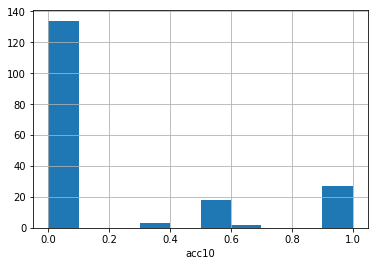

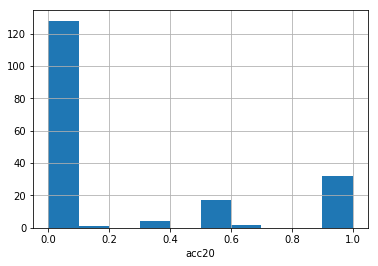

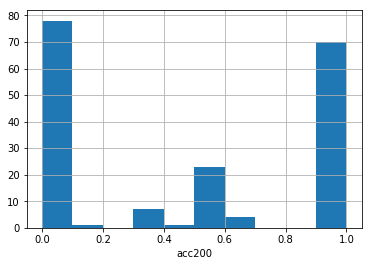

In [167]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [149]:
k = '59a7bc6d782b1b893a56a8b9'
print(k)
preds[k]

59a7bc6d782b1b893a56a8b9


['5984bac6b6b1134fb4638535',
 '5984ce6fb6b1132a53638538',
 '5984bab2b6b1134fcf6384f5',
 '5984b5b6b6b113067263852b',
 '5984d605b6b113780363854d',
 '5984d240b6b1134f2f638502',
 '5984b670b6b113138f63853e',
 '5984cdacb6b1132594638513',
 '5984d73db6b11301f9638504',
 '5984c78bb6b11367c4638543',
 '5984c78bb6b11367c4638542',
 '5984b7bcb6b1132865638503',
 '5984b8f1b6b1133a656384ff',
 '5984be4fb6b1137ca06384fb',
 '5984c744b6b113658e6384f4',
 '5984b81fb6b1132cab638523',
 '5984b865b6b1132fe963853c',
 '5984be01b6b11376e6638539',
 '5984c099b6b11319d2638536',
 '5984dc9cb6b1132dcb638519',
 '5984b847b6b1132ed66384ee',
 '5984b588b6b11304876384ee',
 '5984c577b6b11351b9638527',
 '5984bf7bb6b11308f263852a',
 '5984ce42b6b11328e6638541',
 '5984bf26b6b113065c6384f0',
 '5984c4c5b6b11348b66384f8',
 '5984d73cb6b113021563850b',
 '5984cdb5b6b1132595638529',
 '5984b696b6b113159b63851c',
 '5984b7a2b6b113267e63851f',
 '5984b6c5b6b11317aa63854b',
 '5984b704b6b1131ac863851e',
 '5984b90cb6b1133b70638515',
 '5984c950b6b1

In [150]:
predict([k], lim=10**9)[k].index('5984c686b6b113599c63854c')

107

# Develop

In [83]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():

        arr = np.array([[1,2,3], [4,5,6], [7,8,9]], dtype=np.float32)
        
        m = tf.nn.l2_normalize(arr, dim=1)
        
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[[ 0.26726124  0.53452247  0.80178368]
 [ 0.45584232  0.56980288  0.6837635 ]
 [ 0.50257069  0.57436651  0.64616233]]


In [84]:
np.array([1.,2.,3.])/np.sqrt(1+4+9)

array([ 0.26726124,  0.53452248,  0.80178373])

In [81]:
0.26726124**2 + 0.53452247**2 + 0.80178368**2

0.9999999108555808